# Equivalent Circuit Modeling of EDT Schottky Junction # 

This notebook summarizes my attempt to fit the $\frac{G}{\omega}$ data to the equivalent circuit I derived in my lab notebook. 



In [1]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
import matplotlib as mpl
%matplotlib inline

#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False




os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\EDT_schottky\09_2017_m1\data\data')

# os.listdir()
tmax = 8
T = np.linspace(220,220+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 0

nPoints = 200
master0mv = np.zeros((tmax,nPoints,5))

gOmega = np.zeros((tmax,nPoints,5))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the G/w data with the following format:
#      index 0 is frequency in rad/s
#      index 1 is G/w(w) in Ss^(-1)
#      index 2 is Re(Z) in kOhmcm^{-2}
#      index 3 is Im(Z) in kOhmcm^{-2}
#      index 4 is |Z| in kOhmcm^{-2}



for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master0mv[t,:,0] = tmp1[2:,0]
    master0mv[t,:,1] = savitzky_golay(tmp1[2:,1],51,5)
    master0mv[t,:,2] = savitzky_golay(tmp1[2:,2],51,5)
    master0mv[t,:,3] = savitzky_golay(tmp1[2:,3],51,5)
    master0mv[t,:,4] = savitzky_golay(tmp1[2:,4],51,5)

    gOmega[t,:,0] = master0mv[t,:,0]
    gOmega[t,:,1] = (master0mv[t,:,4]/master0mv[t,:,0])
    gOmega[t,:,2] = ((master0mv[t,:,4]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    gOmega[t,:,3] = ((-master0mv[t,:,2]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    gOmega[t,:,4] = np.sqrt((gOmega[t,:,2]**2) + (gOmega[t,:,3]**2))
 
    
# define some simple functions to make the analysis code a bit more concise
def Gw(T):
    return gOmega[T,:,1]

def w(T):
    return master0mv[t,:,0]

def Zmag(T):
    return gOmega[T,:,4]

# input useful constants
kB = 8.617e-5

# make colormap corresponding to full dat set
colSet_tot = (cm.jet(np.linspace(0,1,11)))

# colormap offsets to correctly color the data
cOff1 = 3
cOff2 = 11

# make colormap corresponding to temeperature range we want to fit
colSet = colSet_tot[cOff1:cOff2]

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\EDT_schottky\manuscript_figs\si_figs\conductance'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 0

Plot the data to make sure we did this right.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


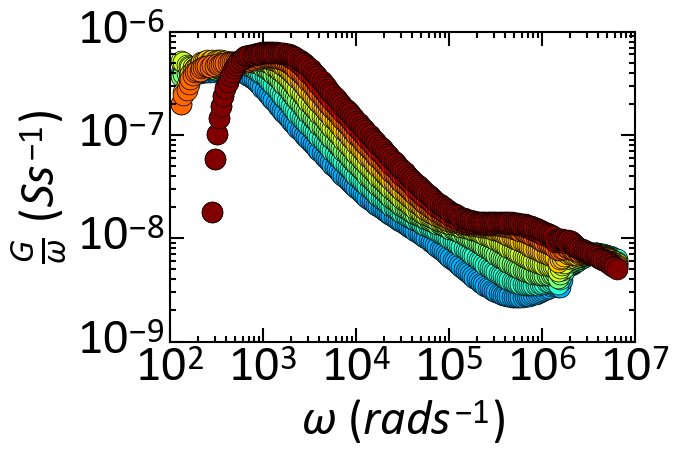

In [3]:
# G/omega plot
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Gw(t),'o',c = c, markersize = 15)
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\G-omega_all_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')



Ok so far so good. Now let's try our fitting function for the test temperature Tt.

In [4]:
# define a function for the G/w response of a single RC branch
def branch(w,Ct,tau_t):
    return (w*Ct*tau_t)/(1+((w**2)*(tau_t**2)))

def branch_log(w,Ct,tau_t):
    return np.log((w*Ct*tau_t)/(1+((w**2)*(tau_t**2))))

from lmfit import Model


0.00113682102209 3.8727599603e-06


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


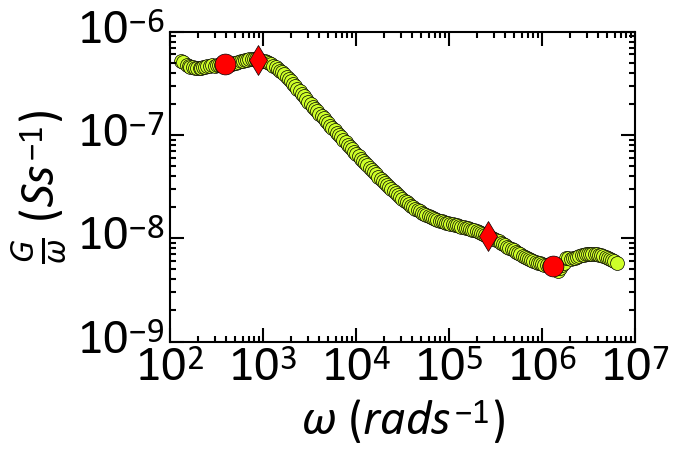

In [5]:
# define a test temperature
Tt = 3
# G/omega plot
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[20],Gw(Tt)[20],'o',c='r', markersize = 15)
ax.plot(w(Tt)[170],Gw(Tt)[170],'o',c='r', markersize = 15)


ax.plot(w(Tt)[35],Gw(Tt)[35],'d',c='r', markersize = 15)
ax.plot(w(Tt)[140],Gw(Tt)[140],'d',c='r', markersize = 15)

ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# set frequency bounds to help fit
bound1 = 20
bound2= 170

# set \tau guesses
tau1 = 1/w(Tt)[35]
tau2 = 1/w(Tt)[140]

print(tau1,tau2)



[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 150
    # variables        = 4
    chi-square         = 3.2401e-08
    reduced chi-square = 2.2193e-10
    Akaike info crit   = -3330.35576
    Bayesian info crit = -3318.31322
[[Variables]]
    t1_Ct:     1.0984e-06 +/- 9.1531e-09 (0.83%) (init = 2e-06)
    t1_tau_t:  0.00152338 +/- 1.9971e-05 (1.31%) (init = 0.001136821)
    t2_Ct:     1.6504e-08 +/- 5.3276e-10 (3.23%) (init = 1.4e-08)
    t2_tau_t:  3.7076e-06 +/- 1.9686e-07 (5.31%) (init = 3.87276e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(t1_Ct, t1_tau_t) =  0.843
    C(t2_Ct, t2_tau_t) =  0.681
    C(t1_tau_t, t2_Ct) =  0.113



C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


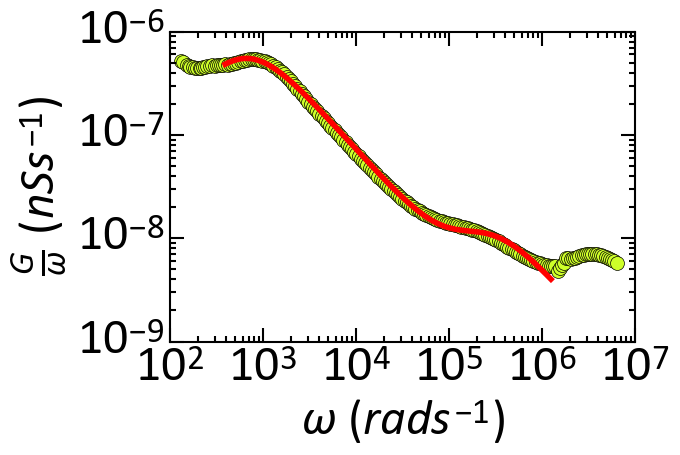

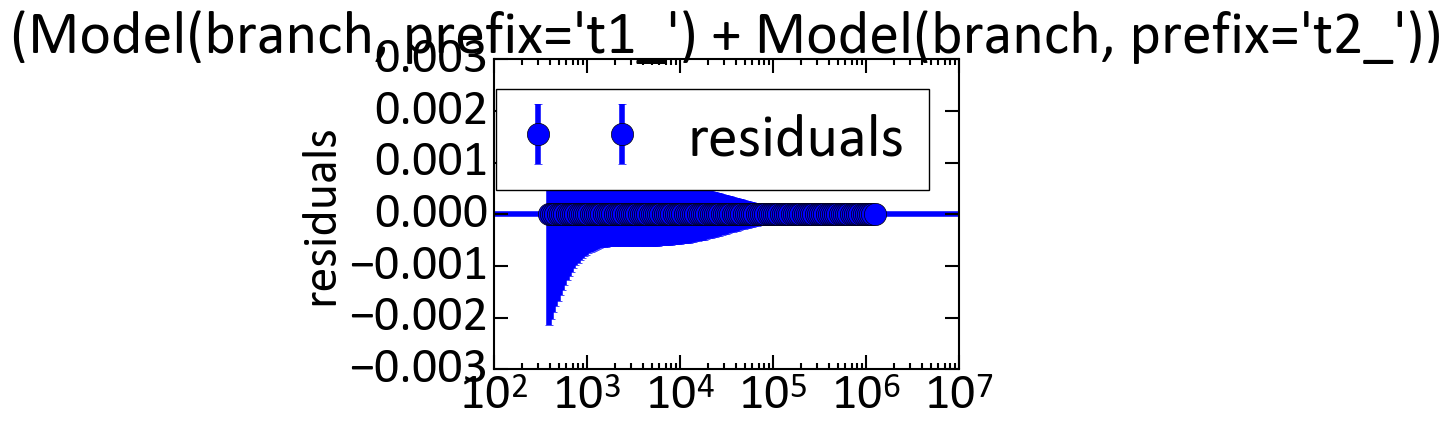

In [6]:
# define and run an aggregate conductance model

# define the name for each of the models. note that prefix 't1' is for interface states, 't2' is for deep traps
branch1 = Model(branch,prefix = 't1_')
branch2 = Model(branch,prefix = 't2_')

# define the aggregate moel
gModel = branch1 + branch2

# add parameters with guesses
params = lmf.Parameters()  

params.add('t1_Ct',value = 5e-6, min = 1e-8, max = 2e-6)
# params.add('t1_tau_t',value = tau1, vary = False, min = 0, max = 1e-1)
params.add('t1_tau_t',value = tau1, min = 0, max = 1e-2)

params.add('t2_Ct',value = 1.4e-8, min = 0, max = 1e-7)
# params.add('t2_tau_t',value = tau2,vary = False, min = 0, max = 1e-3)
params.add('t2_tau_t',value = tau2, min = 0, max = 1e-5)

# ensure data is run over proper range
data = (Gw(Tt)[bound1:bound2])
weights = 1/(.01*Zmag(Tt)[bound1:bound2])

#try the fit
fit_result = gModel.fit(data, w = w(Tt)[bound1:bound2],params = params,weights = weights)
print(fit_result.fit_report())

# G/w with fit
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[bound1:bound2],fit_result.best_fit,color = 'r')
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($nSs^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")


fig,ax = plt.subplots(1,1)
fit_result.plot_residuals(ax=ax)
ax.set_xscale('log')
# ax.set_xlim([5e2,1e4])
# ax.set_ylim([-1e4,1e4])


In [7]:
print(fit_result.params['t1_tau_t'].value*2*np.pi)

print(0.0131*fit_result.params['t1_tau_t'].value*2*np.pi)

print(9.6e-3/1.09e-6)
print(2.31e-5/1.65e-8)

0.00957169827735
0.000125389247433
8807.339449541285
1400.0


[ 0.00174896  0.00148743  0.00113682  0.00113682  0.00077637  0.00066039
  0.00056239  0.00050365]
[  1.14261572e-05   8.71843017e-06   6.65224425e-06   3.87275996e-06
   2.95491994e-06   2.25460672e-06   1.72025923e-06   1.46253888e-06]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


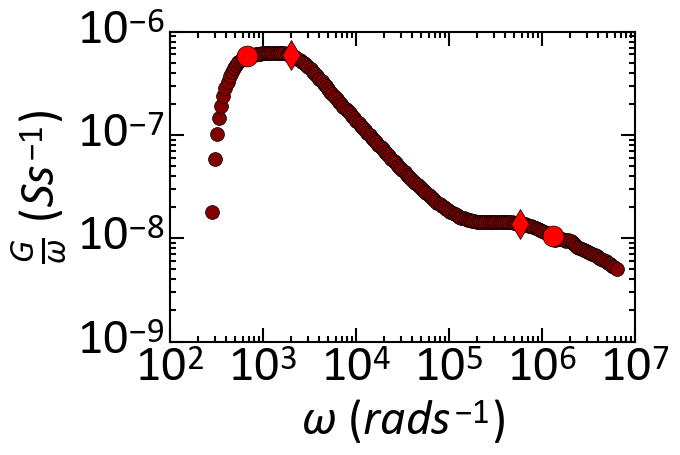

In [8]:
# input fit parameters for all temperatures

# define a test temperature
Tt = 7
# G/omega plot
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[30],Gw(Tt)[30],'o',c='r', markersize = 15)
ax.plot(w(Tt)[170],Gw(Tt)[170],'o',c='r', markersize = 15)


ax.plot(w(Tt)[50],Gw(Tt)[50],'d',c='r', markersize = 15)
ax.plot(w(Tt)[155],Gw(Tt)[155],'d',c='r', markersize = 15)

ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

bound1 = np.zeros(tmax)
tau1 = np.zeros(tmax)

bound2 = np.zeros(tmax)
tau2 = np.zeros(tmax)

bound1[0] = 5
bound1[1] = 15
bound1[2] = 18
bound1[3] = 20
bound1[4] = 20
bound1[5] = 20
bound1[6] = 30
bound1[7] = 30

bound2[0] = 150
bound2[1] = 150
bound2[2] = 163
bound2[3] = 170
bound2[4] = 170
bound2[5] = 170
bound2[6] = 170
bound2[7] = 170

tau1[0] = 1/w(Tt)[27]
tau1[1] = 1/w(Tt)[30]
tau1[2] = 1/w(Tt)[35]
tau1[3] = 1/w(Tt)[35]
tau1[4] = 1/w(Tt)[42]
tau1[5] = 1/w(Tt)[45]
tau1[6] = 1/w(Tt)[48]
tau1[7] = 1/w(Tt)[50]

tau2[0] = 1/w(Tt)[120]
tau2[1] = 1/w(Tt)[125]
tau2[2] = 1/w(Tt)[130]
tau2[3] = 1/w(Tt)[140]
tau2[4] = 1/w(Tt)[145]
tau2[5] = 1/w(Tt)[150]
tau2[6] = 1/w(Tt)[155]
tau2[7] = 1/w(Tt)[158]

print(tau1)

print(tau2)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 145
    # variables        = 4
    chi-square         = 3.5928e-11
    reduced chi-square = 2.5481e-13
    Akaike info crit   = -4200.80409
    Bayesian info crit = -4188.89716
[[Variables]]
    t1_Ct:     8.9418e-07 +/- 6.4690e-09 (0.72%) (init = 9e-07)
    t1_tau_t:  0.00291142 +/- 3.3610e-05 (1.15%) (init = 0.001748955)
    t2_Ct:     8.6165e-09 +/- 7.2960e-10 (8.47%) (init = 1e-08)
    t2_tau_t:  1.3966e-05 +/- 1.7323e-06 (12.40%) (init = 1.142616e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(t1_Ct, t1_tau_t) =  0.814
    C(t2_Ct, t2_tau_t) =  0.737
    C(t1_tau_t, t2_Ct) =  0.136

1
[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 135
    # variables      

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


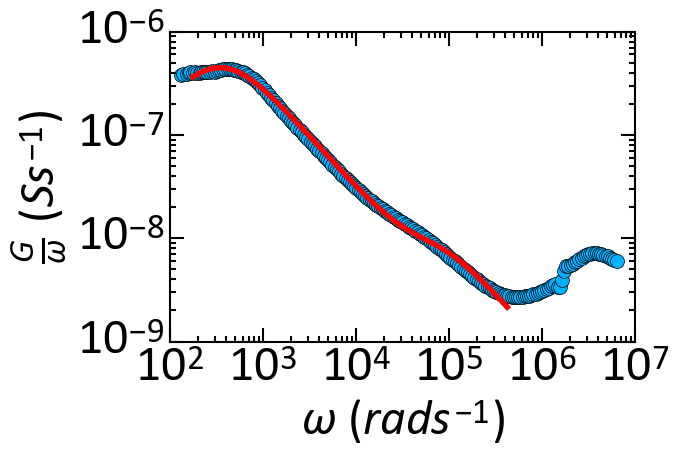

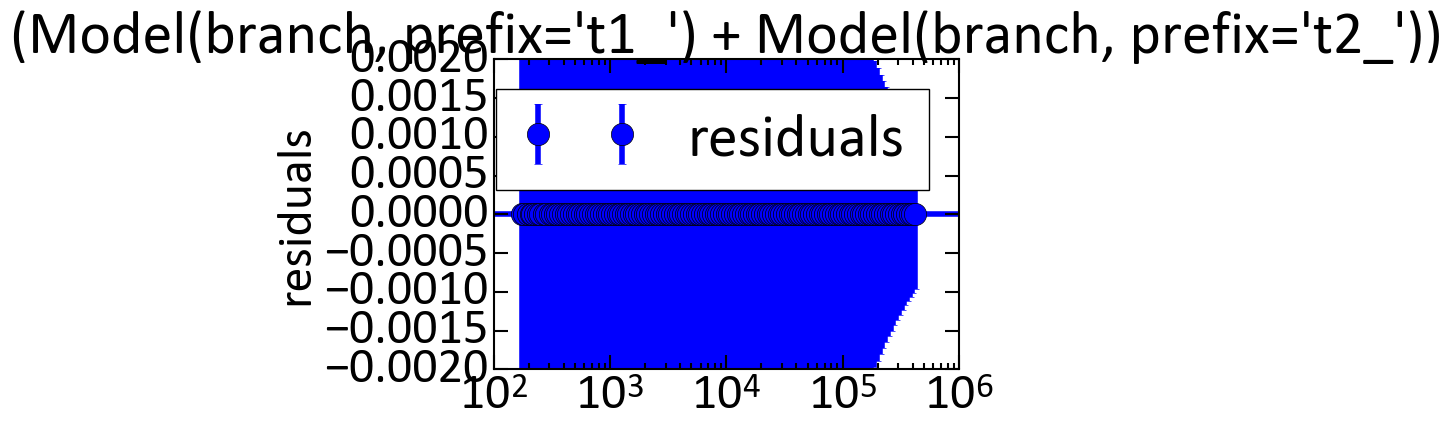

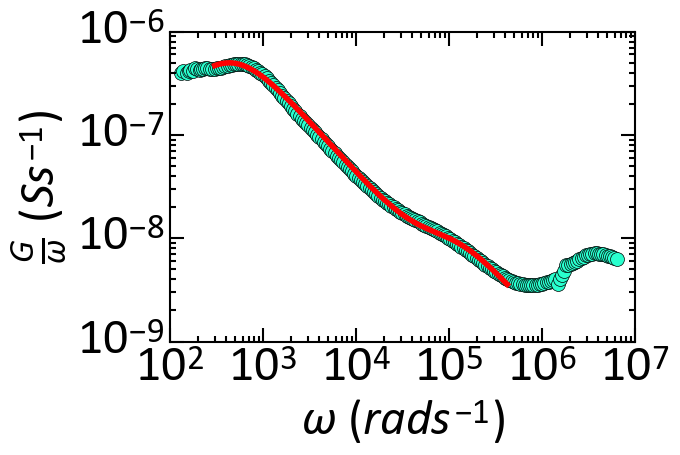

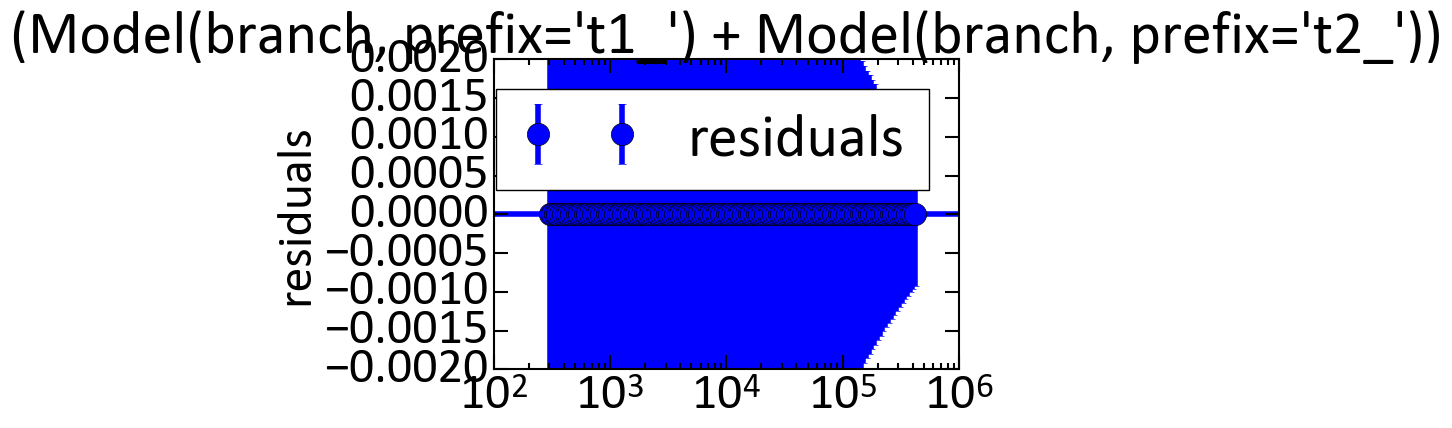

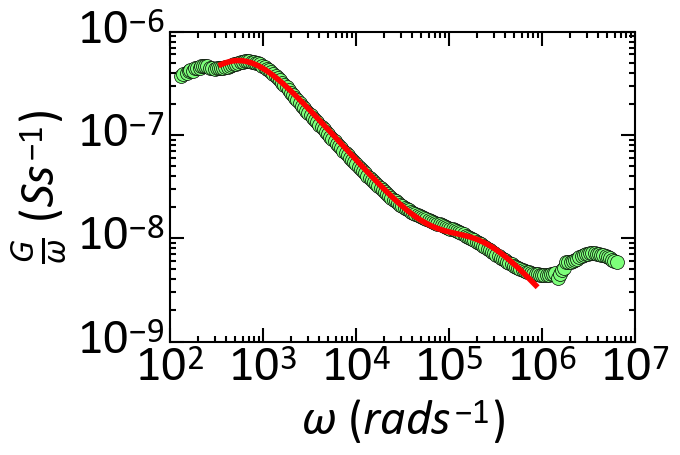

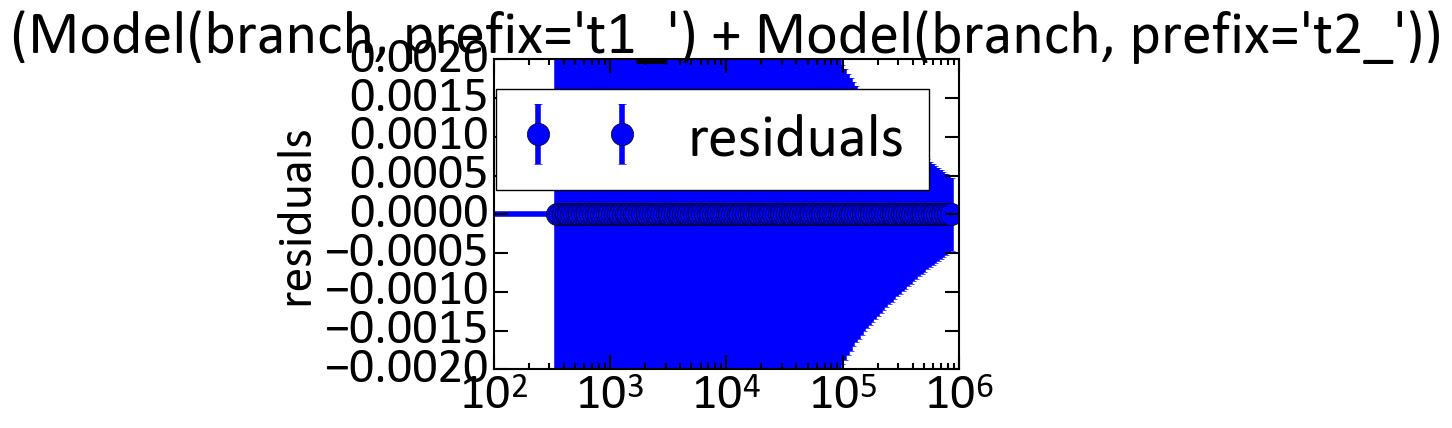

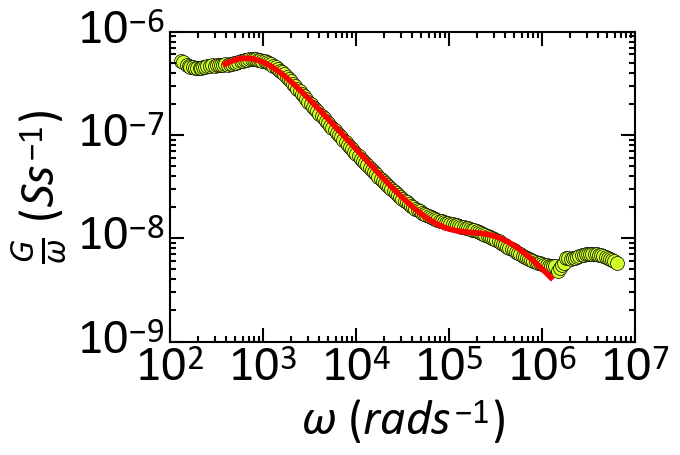

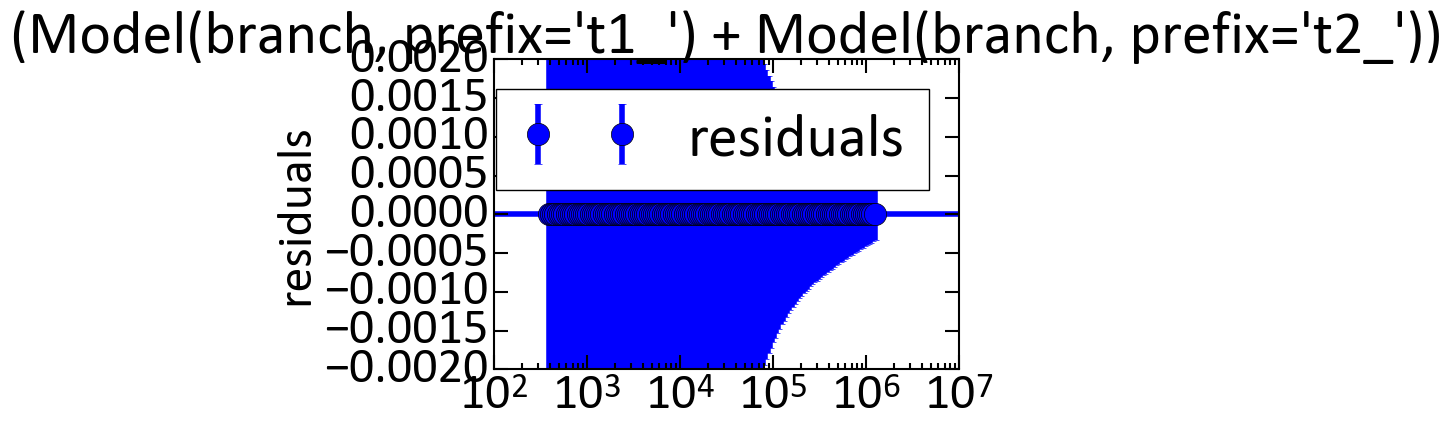

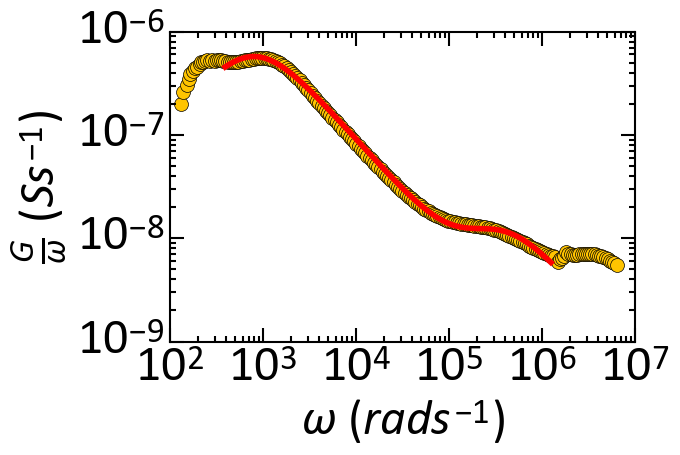

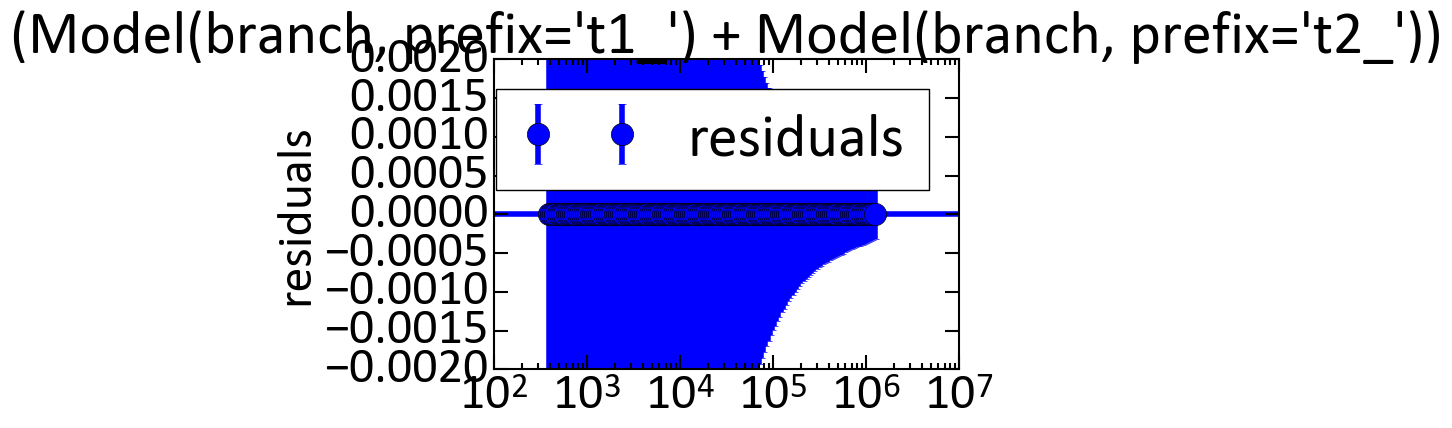

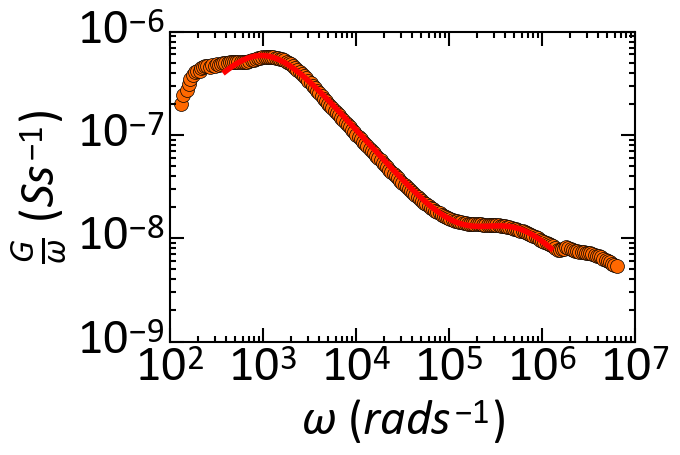

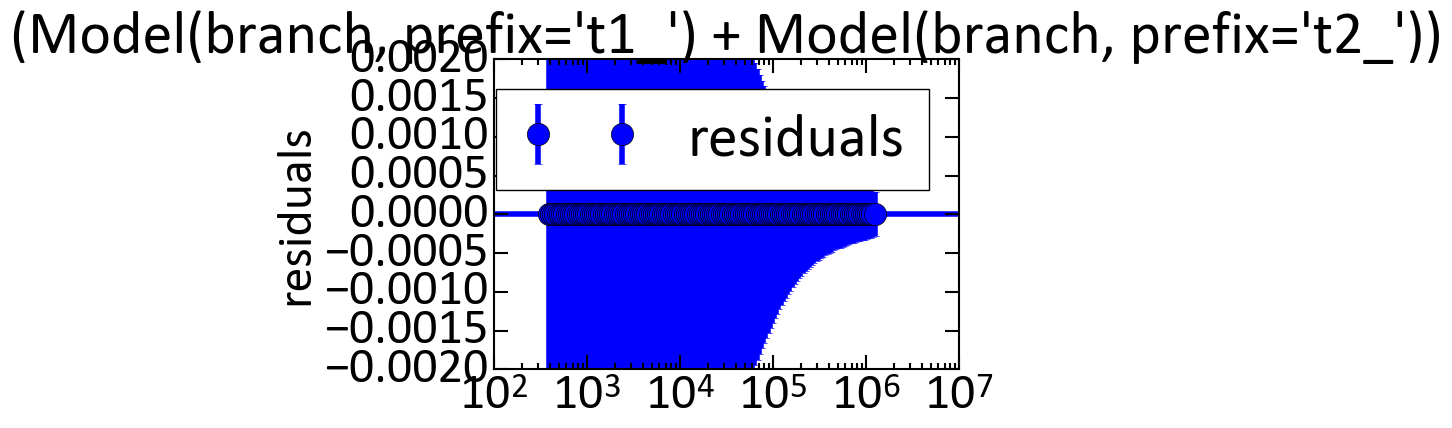

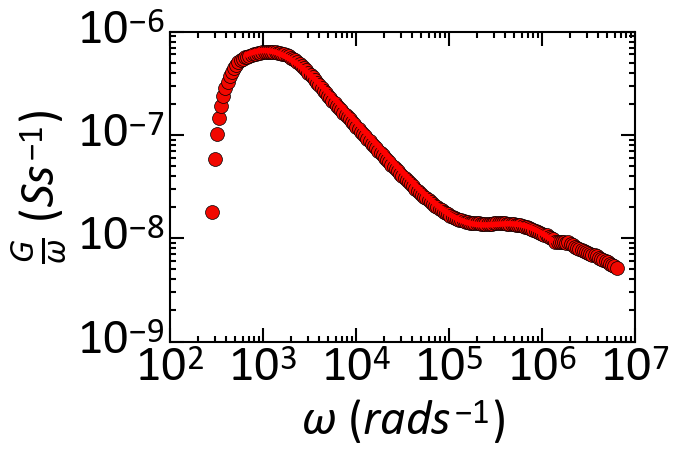

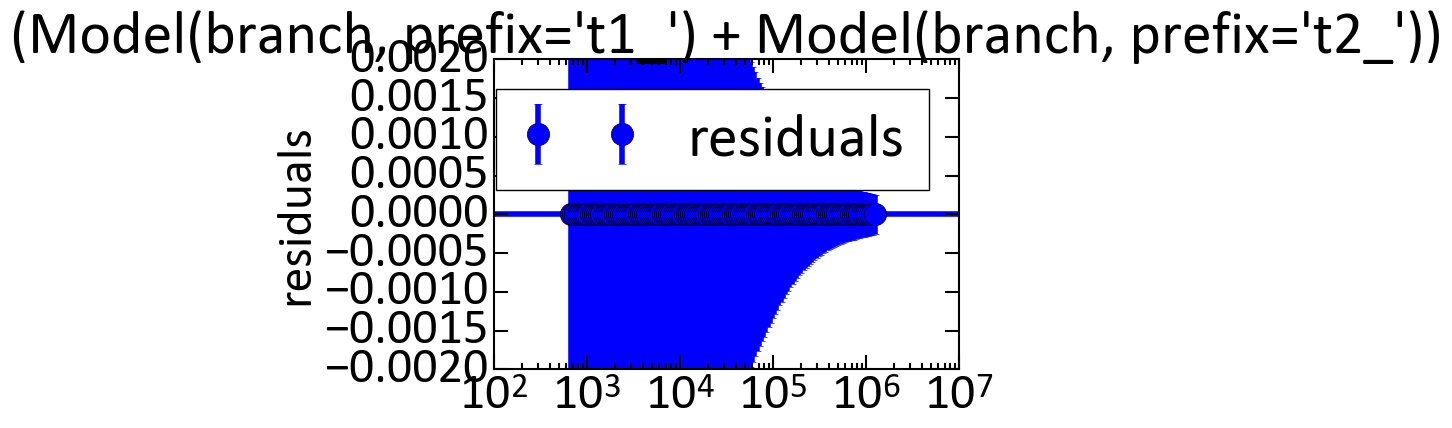

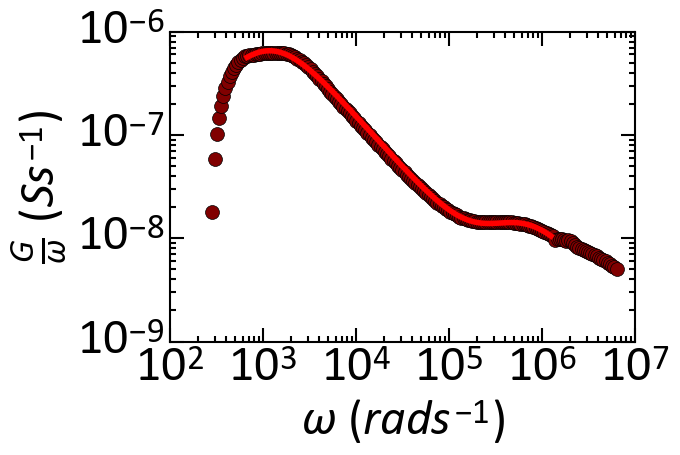

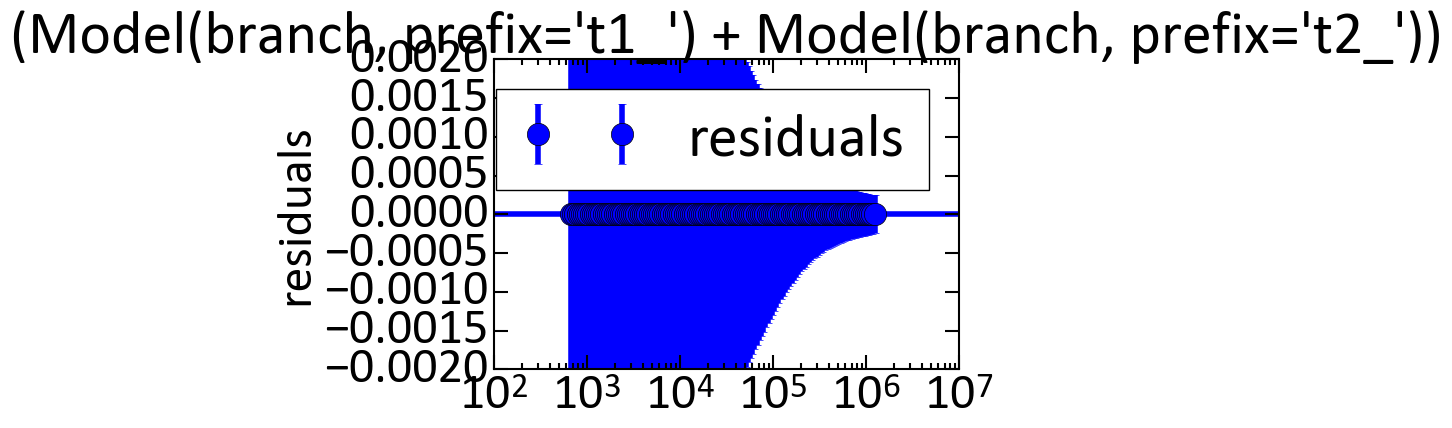

In [9]:
# run the fit in a loop

# define the name for each of the models. note that prefix 't1' is for interface states, 't2' is for deep traps
branch1 = Model(branch,prefix = 't1_')
branch2 = Model(branch,prefix = 't2_')

# define the aggregate moel
gModel = branch1 + branch2

# empty arrays for storing fit parameters
Ct1_fits = []
tau1_fits = []
Ct2_fits = []
tau2_fits =[]

Ct1_err = []
tau1_err =[]
Ct2_err =[]
tau2_err =[]

fitResult_tot = []


# add parameters with guesses
params = lmf.Parameters()  

for t in range(0,tmax):

    params.add('t1_Ct',value = 9e-7, min = 1e-7, max = 2e-6)
    # params.add('t1_tau_t',value = tau1, vary = False, min = 0, max = 1e-1)
    params.add('t1_tau_t',value = tau1[t], min = 0, max = 1e-2)

    params.add('t2_Ct',value = 1e-8, min = 0, max = 1e-7)
    # params.add('t2_tau_t',value = tau2,vary = False, min = 0, max = 1e-3)
    params.add('t2_tau_t', value = tau2[t], min = 0, max = 2e-4)

    # ensure data is run over proper range
    data = (Gw(t)[bound1[t]:bound2[t]])
    weights = 1/(.1*Zmag(t)[bound1[t]:bound2[t]])

    #try the fit
    fit_result = gModel.fit(data, w = w(t)[bound1[t]:bound2[t]],params = params,weights = weights)
    
    Ct1_fits.append(fit_result.params['t1_Ct'].value)
    tau1_fits.append(fit_result.params['t1_tau_t'].value)
    Ct2_fits.append(fit_result.params['t2_Ct'].value)
    tau2_fits.append(fit_result.params['t2_tau_t'].value)
    
    Ct1_err.append(fit_result.params['t1_Ct'].stderr)
    tau1_err.append(fit_result.params['t1_tau_t'].stderr)
    Ct2_err.append(fit_result.params['t2_Ct'].stderr)
    tau2_err.append(fit_result.params['t2_tau_t'].stderr)
    
    fitResult_tot.append(fit_result.best_fit)
    
    print(t)
    print(fit_result.fit_report())


    # G/w with fit
    fig,ax = plt.subplots(1,1)
    ax.plot(w(t),Gw(t),'o',c = tuple(colSet[t]), markersize = 10)
    ax.plot(w(Tt)[bound1[t]:bound2[t]],fit_result.best_fit,color = 'r')
    ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
    ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
    ax.set_xscale("log") 
    ax.set_yscale("log")
#     figName = '\\G-omega_'+ np.array2string(T[t].astype(int)) + 'K_extended.png'
#     plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


    fig,ax = plt.subplots(1,1)
    fit_result.plot_residuals(ax=ax)
    ax.set_xscale('log')
    # ax.set_xlim([5e2,1e4])
    ax.set_ylim([-.002,.002])

Now that we've got our fits, let's calculate the $R_{SRH}$ values and plot them, $C_{t}$, and $\tau_{t}$ vs. temperature.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


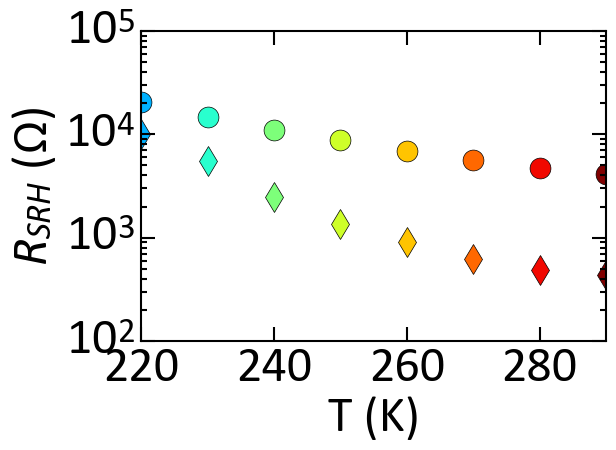

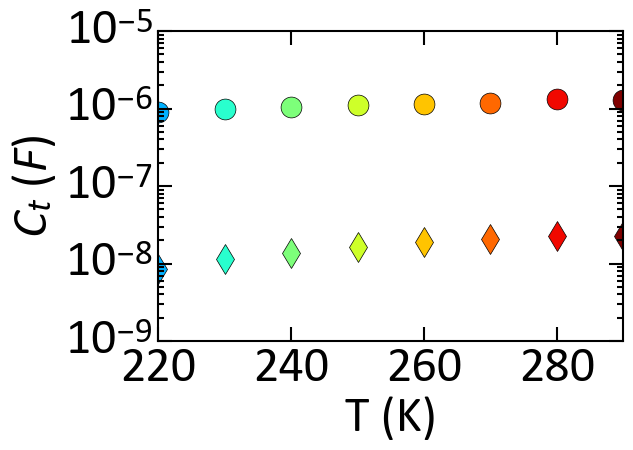

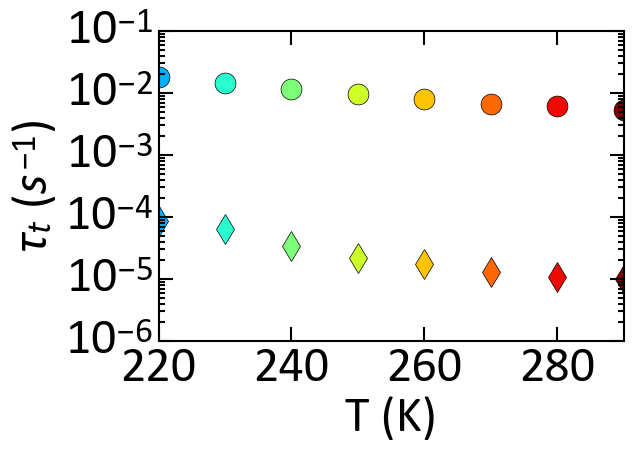

In [10]:
Rt1 = np.zeros(tmax)
Rt2 = np.zeros(tmax)

Rt1_err = np.zeros(tmax)
Rt2_err = np.zeros(tmax)

tau1_val = np.zeros(tmax)
tau2_val = np.zeros(tmax)

tau1_valErr = np.zeros(tmax)
tau2_valErr = np.zeros(tmax)

np.asarray(Ct1_fits)
np.asarray(tau1_fits)
np.asarray(Ct2_fits)
np.asarray(tau2_fits)

np.asarray(Ct1_err)
np.asarray(tau1_err)
np.asarray(Ct2_err)
np.asarray(tau2_err)

np.asarray(fitResult_tot)

for t in range(0,tmax):
    tau1_val[t] = tau1_fits[t]*2*np.pi
    tau2_val[t] = tau2_fits[t]*2*np.pi
      
    tau1_valErr[t] = (tau1_err[t]/tau1_fits[t]) * tau1_val[t]
    tau2_valErr[t] = (tau2_err[t]/tau2_fits[t]) * tau2_val[t]
    
    Rt1[t] = tau1_val[t]/Ct1_fits[t]
    Rt2[t] = tau2_val[t]/Ct2_fits[t]
    
    Rt1_err[t] = np.sqrt( (Ct1_err[t]/Ct1_fits[t])**2 + (tau1_valErr[t]/tau1_val[t])**2 )
    Rt2_err[t] = np.sqrt( (Ct2_err[t]/Ct2_fits[t])**2 + (tau2_valErr[t]/tau2_val[t])**2 )
    

from matplotlib.ticker import MaxNLocator
    
#  Make plots of temperature dependence of parameters   
fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],Rt1[t],yerr = Rt1_err[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],Rt2[t],yerr = Rt2_err[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$R_{SRH}$ ($\Omega$)")
ax.set_yscale('log')
# ax.set_xlim([210,300])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Rt_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],Ct1_fits[t],yerr = Ct1_err[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],Ct2_fits[t],yerr = Ct2_err[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$C_{t}$ ($F$)")
ax.set_yscale('log')
# ax.set_xlim([210,300])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Ct_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],tau1_val[t],yerr = tau1_valErr[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],tau2_val[t],yerr = tau2_valErr[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$\\tau_{t}$ ($s^{-1}$)")
ax.set_yscale('log')
# ax.set_xlim([210,300])
ax.set_ylim([1e-6,1e-1])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\tauT_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


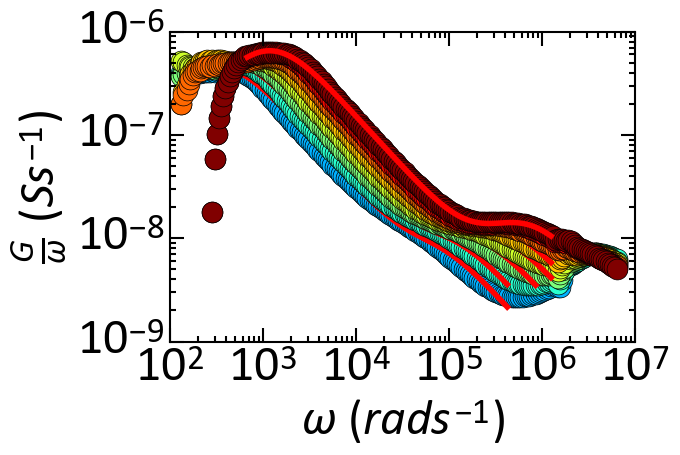

In [11]:
# Make a nice plot of the G-omega plots with the fits

# G/omega plot
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Gw(t),'o',c = c, markersize = 15)
    ax.plot(w(Tt)[bound1[t]:bound2[t]], fitResult_tot[t],'r')
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\G-omega_all_fit_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

For completeness, let's calculate the activation energies of these time constants, paying particularly close attention to the high frequency process

0.0869482139662
0.17042010379
0.126571442059
0.258442325462
-0.0287752298624
-0.0771742234421


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


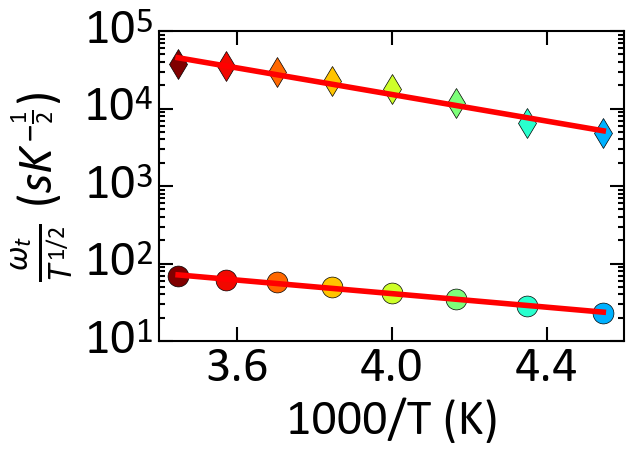

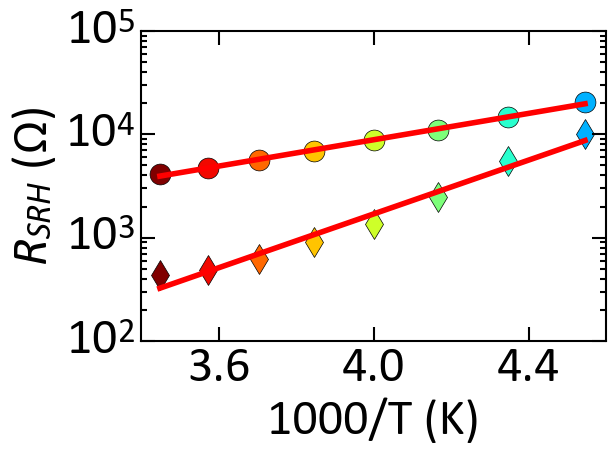

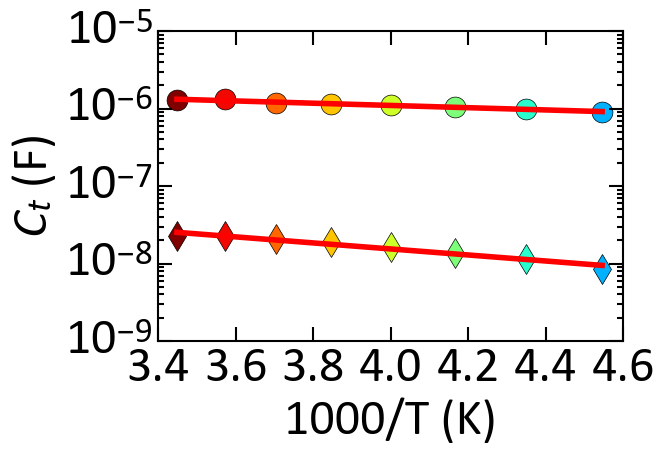

In [12]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)


# first run the fit to the first \tau
xt1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yt1 = np.log(omega_t1/T**(1/2))
mt1,ct1 = np.linalg.lstsq(xt1,yt1)[0]
# print(mt,ct)
Eomega1 = -((kB*mt1)*1e3)
print(Eomega1)
omegaLine1 =  np.exp(mt1*(1e3/T)) * np.exp(ct1)
# print(tauLine)

# off1 = np.where(T ==260)[0][0]

# first run the fit to the second \tau
xt2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yt2 = np.log(omega_t2/T**(1/2))
mt2,ct2 = np.linalg.lstsq(xt2,yt2)[0]
# print(mt,ct)
Eomega2 = -((kB*mt2)*1e3)
print(Eomega2)
omegaLine2 =  np.exp(mt2*(1e3/T)) * np.exp(ct2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],omega_t1[t]/(T[t]**(1/2)),'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],omega_t2[t]/(T[t]**(1/2)),'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,omegaLine1, 'r')
ax.plot(1e3/T,omegaLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\frac{\\omega_t}{T^{1/2}}$ ($sK^{-\\frac{1}{2}}$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\omegaT_both_extended_fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# try a fit to R_SRH as well
xr1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yr1 = np.log(Rt1)
mr1,cr1 = np.linalg.lstsq(xr1,yr1)[0]
# print(mt,ct)
Er1 = ((kB*mr1)*1e3)
print(Er1)
rLine1 =  np.exp(mr1*(1e3/T)) * np.exp(cr1)
# print(tauLine)

# first run the fit to the second R_SRH
xr2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yr2 = np.log(Rt2)
mr2,cr2 = np.linalg.lstsq(xr2,yr2)[0]
# print(mt,ct)
Er2 = ((kB*mr2)*1e3)
print(Er2)
rLine2 =  np.exp(mr2*(1e3/T)) * np.exp(cr2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],Rt1[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],Rt2[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,rLine1, 'r')
ax.plot(1e3/T,rLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{SRH}$ ($\\Omega$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Rt_both_extended)fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# do the same for the capacitance
xc1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yc1 = np.log(Ct1_fits)
mc1,cc1 = np.linalg.lstsq(xc1,yc1)[0]
# print(mt,ct)
Ec1 = ((kB*mc1)*1e3)
print(Ec1)
cLine1 =  np.exp(mc1*(1e3/T)) * np.exp(cc1)
# print(tauLine)

# first run the fit to the second R_SRH
xc2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yc2 = np.log(Ct2_fits)
mc2,cc2 = np.linalg.lstsq(xc2,yc2)[0]
# print(mt,ct)
Ec2 = ((kB*mc2)*1e3)
print(Ec2)
cLine2 =  np.exp(mc2*(1e3/T)) * np.exp(cc2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],Ct1_fits[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],Ct2_fits[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,cLine1, 'r')
ax.plot(1e3/T,cLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$C_{t}$ (F)")
ax.set_yscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Ct_both_extended_fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

In [13]:
print(tau1_val)

print(T)

print(tau1_val/T**2)

[ 0.01829297  0.01464393  0.01163897  0.00961268  0.00794218  0.00657472
  0.00614327  0.00537932]
[ 220.  230.  240.  250.  260.  270.  280.  290.]
[  3.77953951e-07   2.76822851e-07   2.02065468e-07   1.53802940e-07
   1.17487881e-07   9.01881446e-08   7.83580426e-08   6.39633553e-08]


In [14]:
test  = np.asarray(tau1_fits)

print(type(tau1_fits))
print(type(test))
print(test)

# tau1_val[t] = tau1_fits[t]*2*np.pi

<class 'list'>
<class 'numpy.ndarray'>
[ 0.00291142  0.00233065  0.0018524   0.00152991  0.00126404  0.0010464
  0.00097773  0.00085615]


In [15]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)


print(omega_t1)
print(omega_t2)

[  343.47538358   429.06417904   539.84027626   653.6348728    791.11587993
   955.65885319  1022.77528936  1168.02633627]
[  71602.41717315   99295.62080871  182221.59745393  286435.59017871
  366384.38324367  480958.16819077  584054.16982225  633553.56350371]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


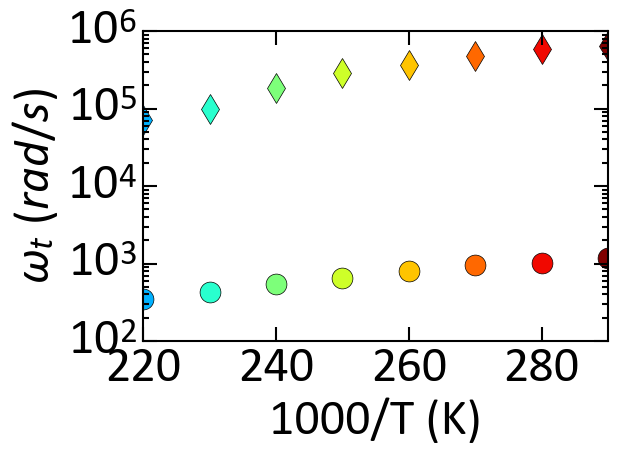

In [16]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(T[t],omega_t1[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(T[t],omega_t2[t],'d',color=tuple(colSet[t]),markersize = 15)
# ax.plot(1e3/T,omegaLine1, 'r')
# ax.plot(1e3/T,omegaLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\omega_t}$ ($rad/s$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))

To try and make sense of this, let's calculate the $E_{\omega}$ value implied by the resonant frequencies. Not that we currently have a super clear physical picture of what each of these should be, but let's just see....

In [17]:
Ew1 = np.zeros(tmax)
Ew2 = np.zeros(tmax)

for t in range(0,tmax):
    Ew1[t] = -kB*T[t]*(np.log(omega_t1[t]/(T[t]**(1/2)))- ct1) 

    Ew2[t] = -kB*T[t]*(np.log(omega_t2[t]/(T[t]**(1/2)))- ct2) 
    
print(Ew1)    
print(Ew2)
    

[ 0.08727914  0.0872773   0.08676235  0.0866966   0.08632696  0.08569001
  0.08766481  0.08791568]
[ 0.17166817  0.17343146  0.16885627  0.16658819  0.16817585  0.16875259
  0.17075552  0.17525948]


Evaluate the high frequency peaks by assuming they represent not a bulk trap but instead the dielectric relaxation process for carriers.

Start by plotting $C$, $\frac{dC}{d\omega}$. Fit the latter to a series of Gaussians. Extract $\omega_{D}$. From Arrhenius plot of $\omega_{D}$, determine activation energy of mobility $E_{A}$ and prefactor $\mu_{0}$.

In [18]:
tmax2 = 11
T = np.linspace(190,190+(10*tmax2),tmax2,endpoint=False)
print(T)

cap = np.zeros((tmax2,nPoints,3))
master0mv2 = np.zeros((tmax2,nPoints,5))
    
    
# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the capacitance data with the following format:
#      index 0 is capacitance in F
#      index 1 is capacitance in nF/cm^2

for t in range(0,tmax2):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file1)
    master0mv2[t,:,0] = tmp2[2:,0]
    master0mv2[t,:,1] = savitzky_golay(tmp2[2:,1],51,5)
    master0mv2[t,:,2] = savitzky_golay(tmp2[2:,2],51,5)
    master0mv2[t,:,3] = savitzky_golay(tmp2[2:,3],51,5)
    master0mv2[t,:,4] = savitzky_golay(tmp2[2:,4],51,5)
    
    cap[t,:,0] = master0mv2[t,:,0]
    cap[t,:,1] = (master0mv2[t,:,1])
    cap[t,:,2] = (master0mv2[t,:,1]*1e9)/4e-2
    
# define some simple functions to make the analysis code a bit more concise
def C(T):
    return cap[T,:,2]

def w2(T):
    return cap[T,:,0]

# print(np.shape(colSet_tot)[0])

# make colormap corresponding to full dat set
colSet2 = (cm.jet(np.linspace(0,1,12)))

[ 190.  200.  210.  220.  230.  240.  250.  260.  270.  280.  290.]


In [19]:
print(T)
print(tmax2)

[ 190.  200.  210.  220.  230.  240.  250.  260.  270.  280.  290.]
11


157
335.245993867
571.238599077
633553.563504
2.28495439631e-08


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


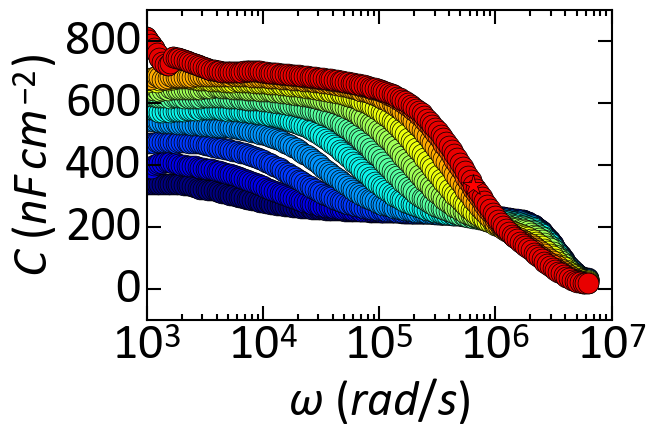

In [20]:
fig,ax = plt.subplots(1,1)
for t in range(0,tmax2):
    ax.plot(w2(t),C(t),'o',color=tuple(colSet2[t]),markersize = 15)

ax.plot(w2(tmax2-1)[157],C(tmax2-1)[157],'r*')
ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$C$ ($nF\, cm^{-2}$)")
ax.set_xscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim([1e3,1e7])


print(np.where(w2(tmax2-1) >= omega_t2[tmax-1] )[0][0])
print(C(tmax2-1)[157])
print((Ct2_fits[7]*1e9)/4e-2)
print(omega_t2[tmax-1])
print(Ct2_fits[7])

(-50, 400)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


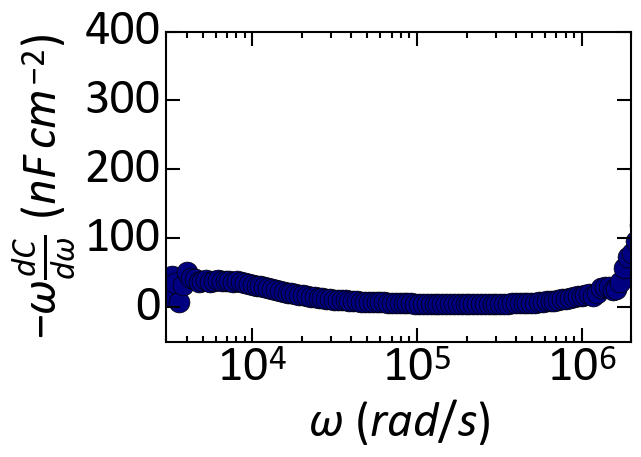

In [21]:
dC = np.zeros((tmax2,nPoints))
dw = np.zeros(nPoints)

dw = np.gradient(w2(1))
for t in range(0,tmax2):
    dC[t,:] = np.gradient(C(t))
    
def wdCdW(T):
    return -w2(T)*(dC[t,:]/dw)


fig,ax = plt.subplots(1,1)
for t in range(0,1):
    ax.plot(w2(t),wdCdW(t),'o',color=tuple(colSet2[t]),markersize = 15)
ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$-\omega \\frac{dC}{d \omega}$ ($nF\, cm^{-2}$)")
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_xlim([3e3,2e6])
ax.set_ylim([-50,400])



Run conductance sanity check

(1000.0, 10000000.0)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


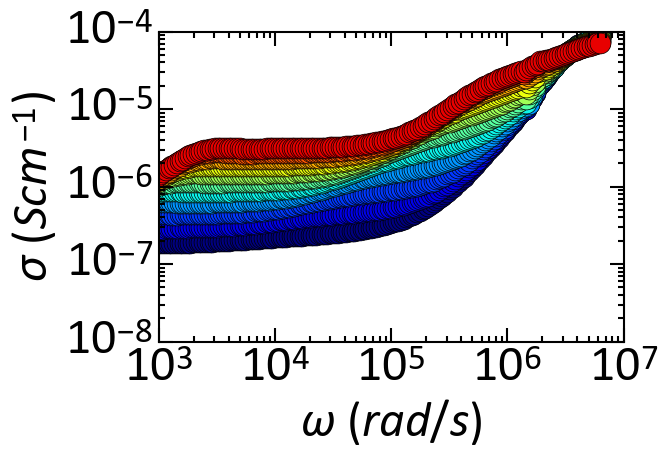

In [22]:
# extract conductivity in Siemens/cm
def sigmaG(T):
    return master0mv2[T,:,4]*(90e-6/4e-2)

# plot conductance data
fig,ax = plt.subplots(1,1)
for t in range(0,tmax2):
    ax.plot(w2(t),sigmaG(t),'o',color=tuple(colSet2[t]),markersize = 15)

ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$\\sigma$ ($S cm^{-1}$)")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim([1e3,1e7])

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


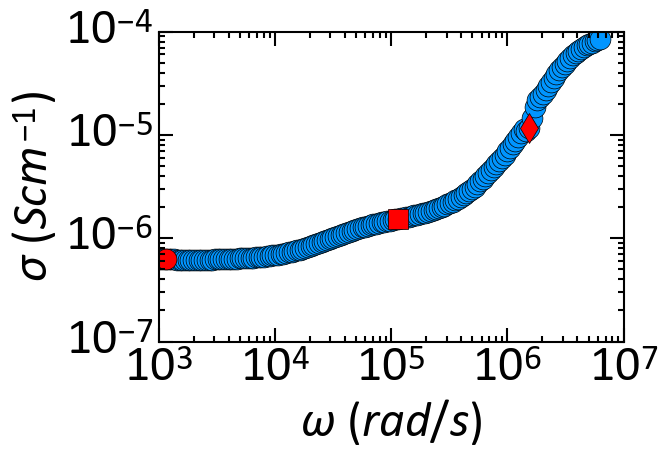

In [23]:
#pick out bounds for linear fits to both regimes (high \omega, low \omega)

Tt = 3
fig,ax = plt.subplots(1,1)

ax.plot(w2(Tt),sigmaG(Tt),'o',color=tuple(colSet2[Tt]),markersize = 15)

ax.plot(w2(Tt)[40],sigmaG(Tt)[40],'o',c='r', markersize = 15)
ax.plot(w2(Tt)[125],sigmaG(Tt)[125],'s',c='r', markersize = 15)
ax.plot(w2(Tt)[173],sigmaG(Tt)[173],'d',c='r', markersize = 15)


ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$\\sigma$ ($S cm^{-1}$)")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim([1e3,1e7])

bound3 = 40


bound4 = np.zeros(tmax2)

bound4[0] = 125
bound4[1] = 125
bound4[2] = 135 
bound4[3] = 135 
bound4[4] = 120
bound4[5] = 110
bound4[6] = 110 
bound4[7] = 110
bound4[8] = 120
bound4[9] = 120 
bound4[10] = 125
# bound4[11] = 125

bound5 = 178


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: Visi

[ 1.45078012  1.2911637   1.29841295  1.08126767  0.67805173  0.60329814
  0.63922128  0.69686216  0.77081543  0.81742805  0.8271252 ]
290.0
[ 190.  200.  210.  220.  230.  240.  250.  260.  270.  280.  290.]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


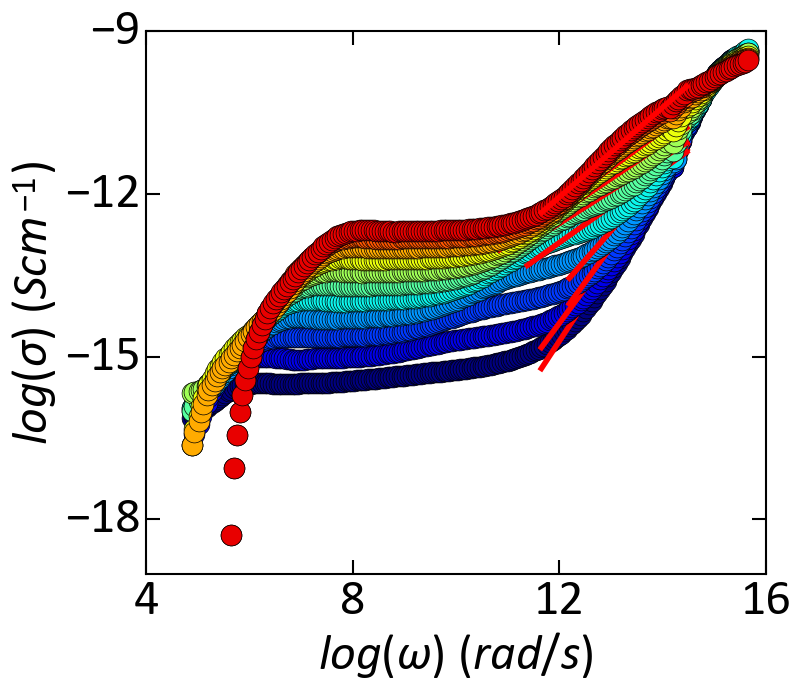

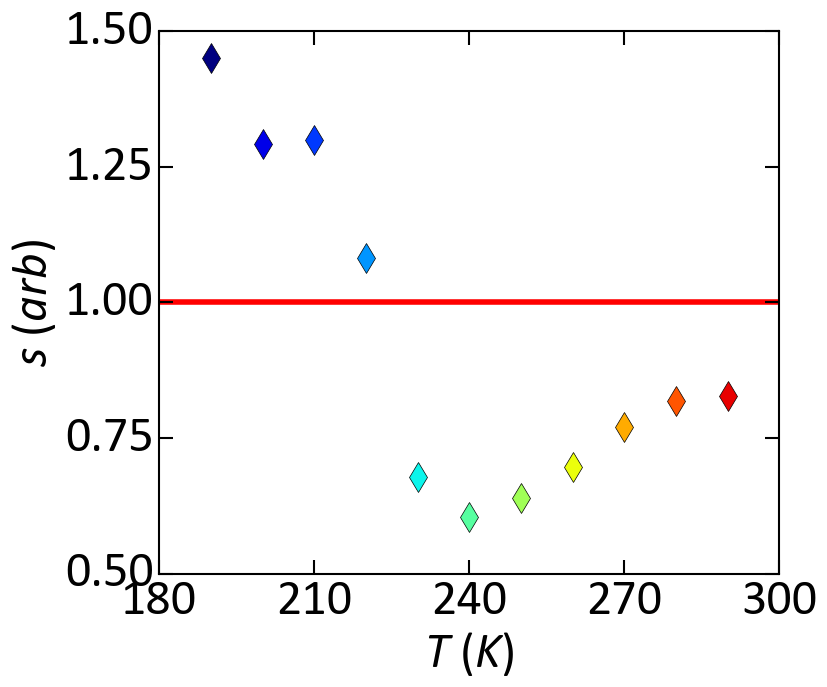

In [24]:
# figures directory for these figs:
fig2Dir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\EDT_schottky\manuscript_figs\si_figs\AC_conductance_analysis'


# perform fits over specified ranges

# data arrays to store fit parameters and lists to store lines
sigmaLowF = np.zeros((2,tmax2))
sigmaHighF = np.zeros((2,tmax2))

lineLowF = []
lineHighF = []

# create list of x- and y-arrays
xSigmaLowF = []
xSigmaHighF = []

ySigmaLowF = []
ySigmaHighF = []

for t in range(0,tmax2):
    xSigmaLowF.append( np.vstack([ np.log(w2(t)[bound3:bound4[t]]) ,np.ones(len(w2(t)[bound3:bound4[t]]))]).T )
    xSigmaHighF.append( np.vstack([ np.log(w2(t)[bound4[t]:bound5]) ,np.ones(len(w2(t)[bound4[t]:bound5]))]).T )

for t in range(0,tmax2):
    ySigmaLowF.append(np.log(sigmaG(t)[bound3:bound4[t]]))
    ySigmaHighF.append(np.log(sigmaG(t)[bound4[t]:bound5]))

# perform fits and create fit lines
for t in range(0,tmax2):
    sigmaLowF[:,t] = np.linalg.lstsq(xSigmaLowF[t],ySigmaLowF[t])[0]
    sigmaHighF[:,t] = np.linalg.lstsq(xSigmaHighF[t],ySigmaHighF[t])[0]
    
    lineLowF.append(sigmaLowF[0,t]*np.log(w2(t)[bound3:bound4[t]]) + sigmaLowF[1,t])
    lineHighF.append(sigmaHighF[0,t]*np.log(w2(t)[bound4[t]:bound5]) + sigmaHighF[1,t])
    
# plot the data with fits
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(np.log(w2(t)),np.log(sigmaG(t)),'o',color=tuple(colSet2[t]),markersize = 15)
    
#     ax.plot(np.log(w2(t)[bound3:bound4[t]]),lineLowF[t],'r')
    ax.plot(np.log(w2(t)[bound4[t]:bound5]),lineHighF[t],'r')
        
ax.set_xlabel("$log(\\omega)$ ($rad/s$)")
ax.set_ylabel("$log(\\sigma)$ ($S cm^{-1}$)")
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
# figName = '\\G_highOmegaFits.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')



# plot s vs. T
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
#     ax.plot(T[t],sigmaLowF[0,t],'o',color=tuple(colSet2[t]),markersize = 15)
    ax.plot(T[t],sigmaHighF[0,t],'d',color=tuple(colSet2[t]),markersize = 15)
plt.axhline(1,color = 'r')

ax.set_xlabel("$T$ ($K$)")
ax.set_ylabel("$s$ ($arb$)")
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.set_ylim([0.5,1.5])
# figName = '\\s_highOmega.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')

print(sigmaHighF[0,:])

print(T[10])
print(T)
    

In [25]:
print(T[4])

230.0


Actvation energy of omegaD: 0.2253758659829975 eV


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


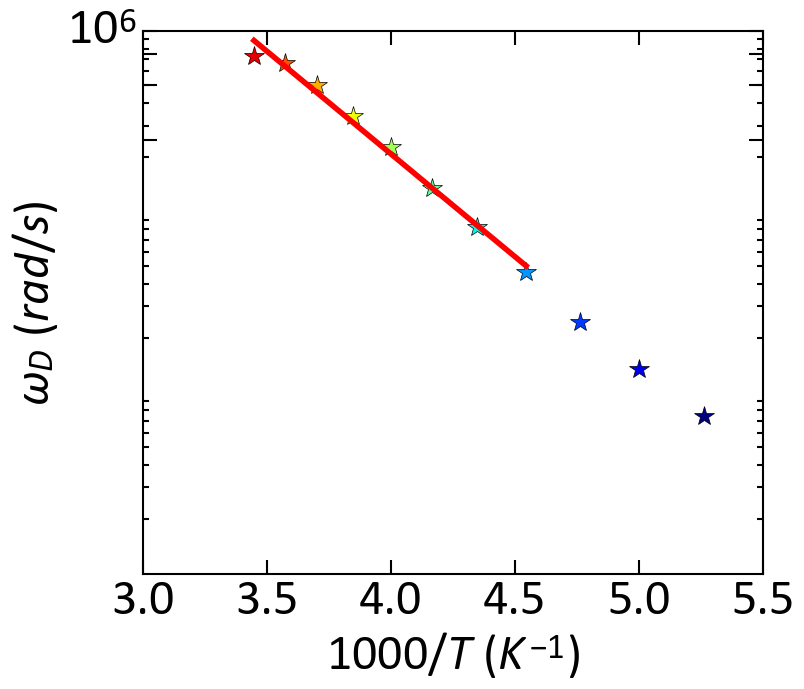

In [26]:
# input freeze out peaks. Note that index 0 refers to T = 190 K
omegaD = np.zeros(tmax2)

omegaD[0] = 7.4001e3
omegaD[1] = 1.3516e4
omegaD[2] = 2.4612e4
omegaD[3] = 4.6299e4
omegaD[4] = 8.2620e4
omegaD[5] = 1.3580e5
omegaD[6] = 2.2703e5
omegaD[7] = 3.3728e5
omegaD[8] = 5.0433e5
omegaD[9] = 6.6188e5
omegaD[10] = 7.3040e5

# pick out indices of omegaD
omegaD_ix = np.zeros(tmax2)
for t in range(0,tmax2):
    omegaD_ix[t] = np.where(w2(t) >= omegaD[t])[0][0]

omegaD_ix = omegaD_ix.astype(int)

# run a fit to omega_D vs. 1/T from T = 230 = 290K
# create data arrays for high omega, high T 
Xwd = np.vstack( [1e3/T[3:],np.ones(len(T[3:]))]).T
Ywd = np.log(omegaD[3:])

# fit to omegaD over range specified above
mD,cD = np.linalg.lstsq(Xwd,Ywd)[0]
E_D = np.abs((kB*mD)*1e3)
dLine =  np.exp(mD*(1e3/T[3:])) * np.exp(cD)

# plot data and fits
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(1e3/T[t],omegaD[t],'*',color = tuple(colSet2[t]),markersize = 15)

ax.plot(1e3/T[3:],dLine[:],color = 'r' )
ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\omega_{D}$ ($rad/s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\sigmaArrFits.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')

print('Actvation energy of omegaD: {} eV'.format(E_D))

In [27]:
print((Ct2_fits[7]*1e9)/4e-2)
# print(Ct2_fits)

571.238599077


Compare this fit to the activation energy of $\omega_{t2}$ from the equivalent circiot model above. Note that the frequencies are different for some reason.... we should include the % difference as an error. 

Actvation energy of omegaD: 0.2253758659829975 eV
Actvation energy of omega_t2: 0.18126810201979204 eV
Actvation energy of Rt2: 0.2584423254619414 eV
Actvation energy of Ct2: -0.07717422344214923 eV


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


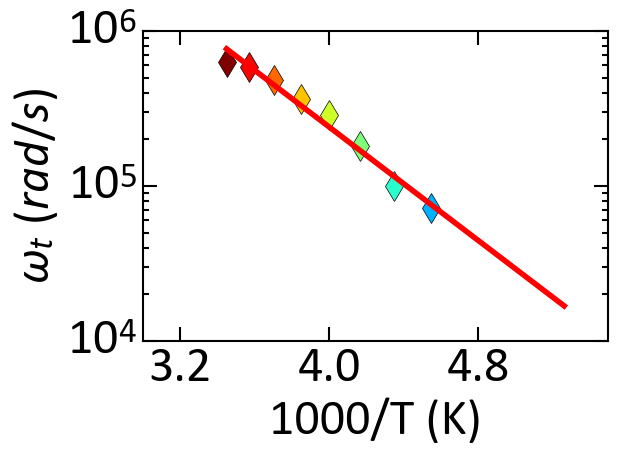

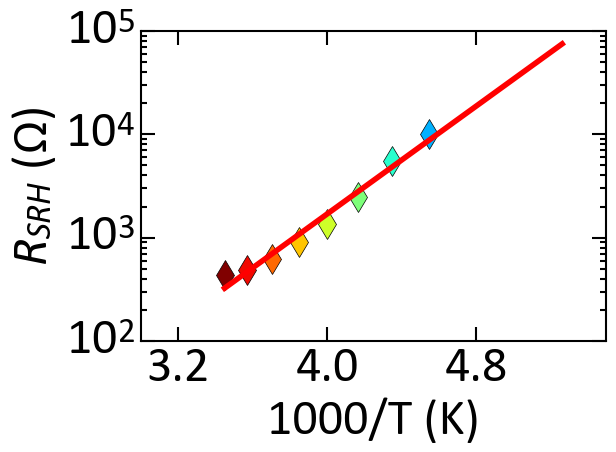

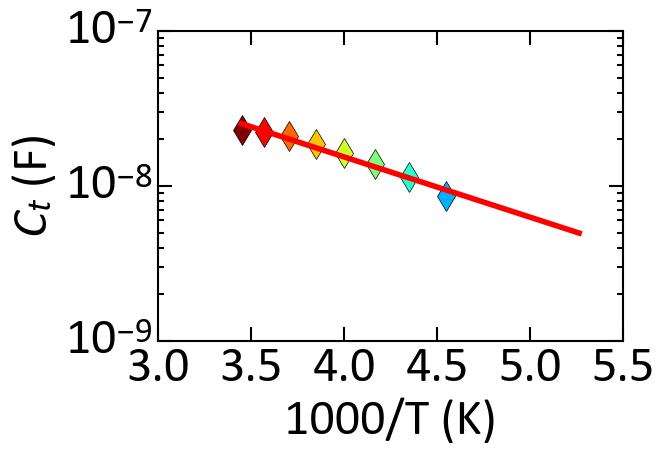

In [28]:
# re-make temperature array from equivalent circuit analysis
T_ec = np.linspace(220,220+(10*tmax),tmax,endpoint=False)

# first run the fit to the second \tau
xt2b = np.vstack( [1e3/T_ec, np.ones(len(T_ec))] ).T
yt2b = np.log(omega_t2)
mt2b,ct2b = np.linalg.lstsq(xt2b,yt2b)[0]
Eomega2b = -((kB*mt2b)*1e3)
omegaLine2b =  np.exp(mt2b*(1e3/T)) * np.exp(ct2b)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T_ec[t],omega_t2[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,omegaLine2b, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("${\\omega_t}$ ($rad/s$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\omegaT_both_extended_fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

# first run the fit to R_SRH
xr2b = np.vstack( [1e3/T_ec, np.ones(len(T_ec))] ).T
yr2b = np.log(Rt2)
mr2b,cr2b = np.linalg.lstsq(xr2,yr2)[0]
Er2b = ((kB*mr2b)*1e3)
rLine2b =  np.exp(mr2b*(1e3/T)) * np.exp(cr2b)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T_ec[t],Rt2[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,rLine2b, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{SRH}$ ($\\Omega$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Rt_both_extended)fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

# run the fit to capacitance
xc2b = np.vstack( [1e3/T_ec, np.ones(len(T_ec))] ).T
yc2b = np.log(Ct2_fits)
mc2b,cc2b = np.linalg.lstsq(xc2b,yc2b)[0]
# print(mt,ct)
Ec2b = ((kB*mc2b)*1e3)
cLine2b =  np.exp(mc2b*(1e3/T)) * np.exp(cc2b)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T_ec[t],Ct2_fits[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,cLine2b, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$C_{t}$ (F)")
ax.set_yscale('log')


print('Actvation energy of omegaD: {} eV'.format(E_D))
print('Actvation energy of omega_t2: {} eV'.format(Eomega2b))
print('Actvation energy of Rt2: {} eV'.format(Er2b))
print('Actvation energy of Ct2: {} eV'.format(Ec2b))

In [29]:
print(omegaD)
print(omega_t2)
print(tmax)
# re-make temperature array from equivalent circuit analysis
T_ec = np.linspace(220,220+(10*tmax),tmax,endpoint=False)
print(T_ec.shape)

[   7400.1   13516.    24612.    46299.    82620.   135800.   227030.
  337280.   504330.   661880.   730400. ]
[  71602.41717315   99295.62080871  182221.59745393  286435.59017871
  366384.38324367  480958.16819077  584054.16982225  633553.56350371]
8
(8,)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


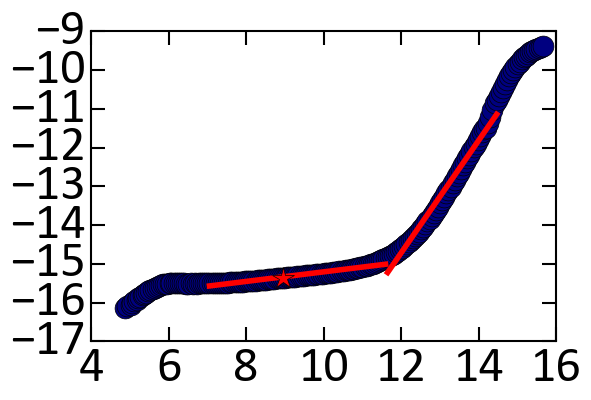

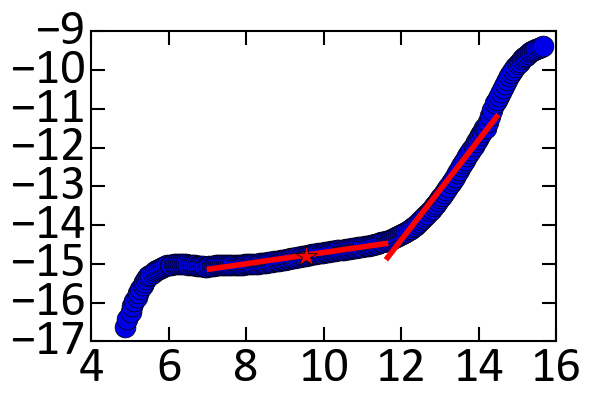

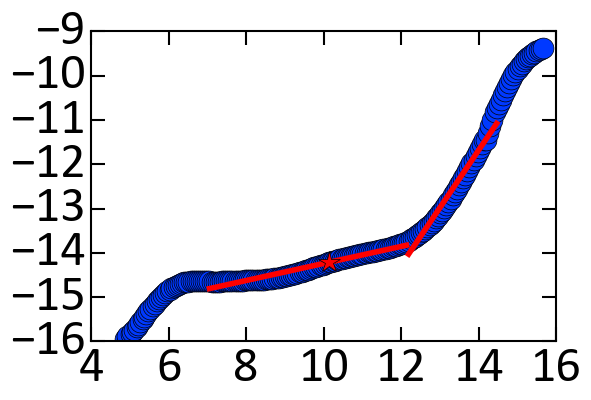

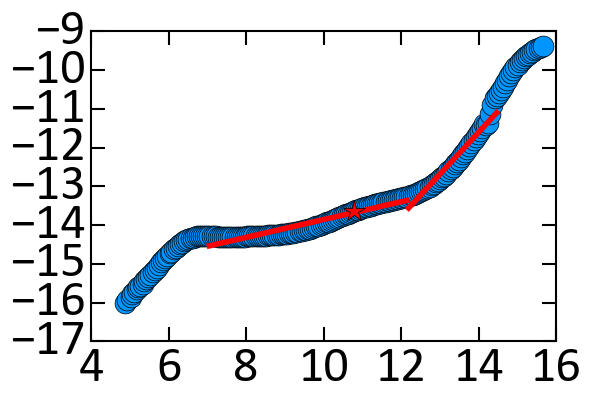

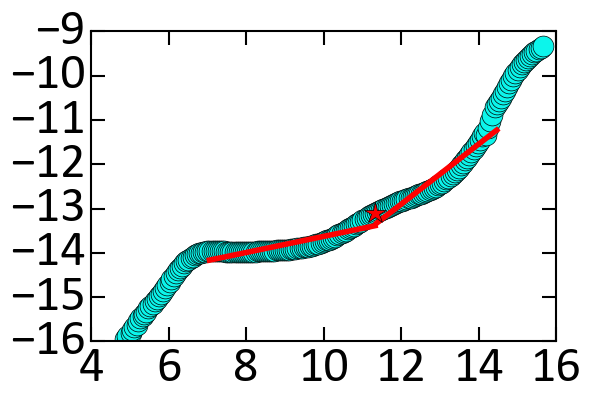

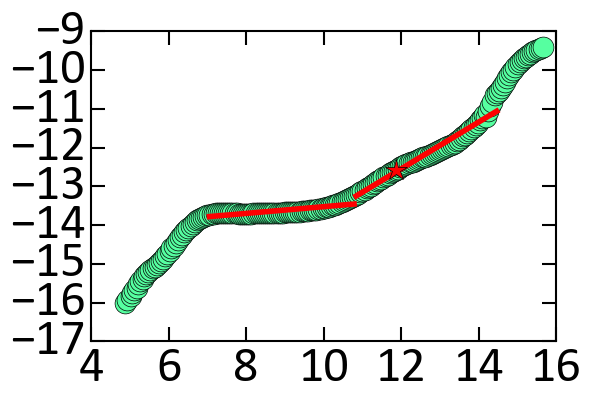

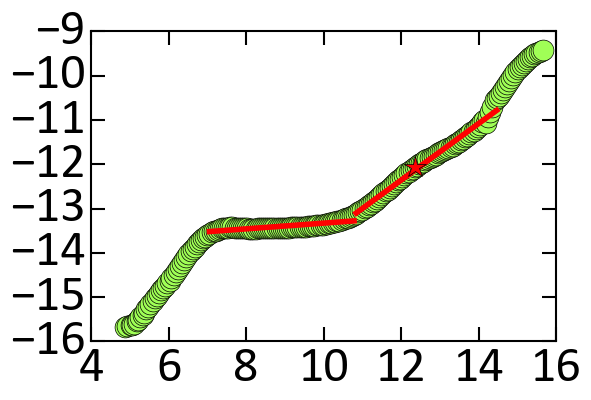

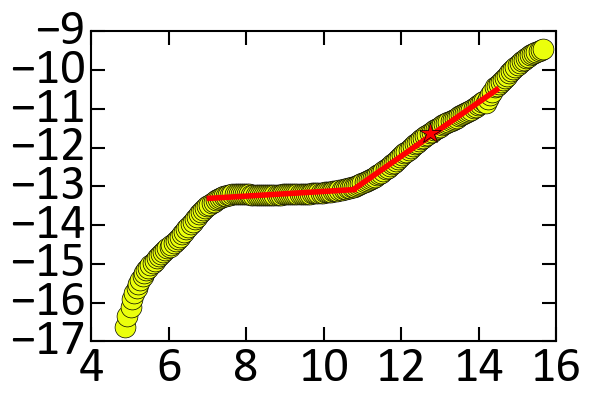

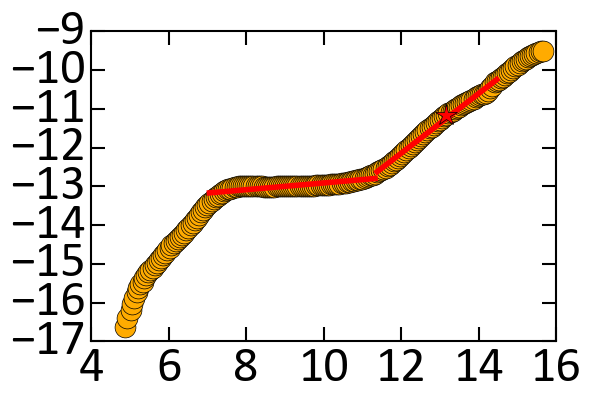

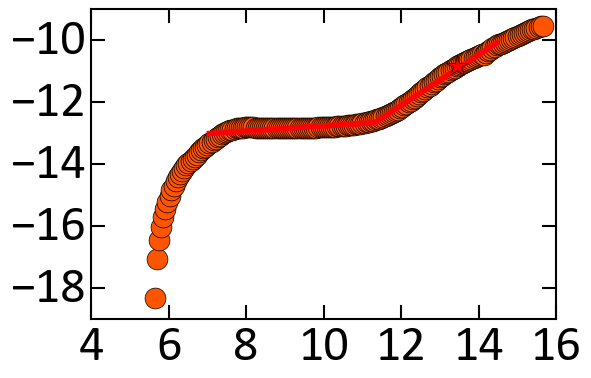

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


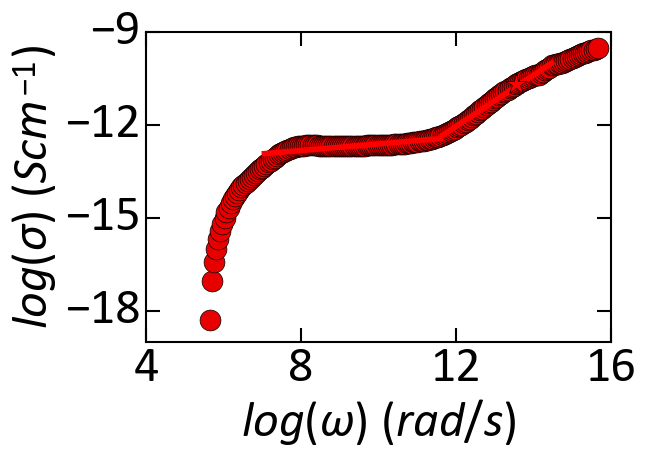

In [30]:
# make a figure for each fit to visually inspect

# plot the data with fits
for t in range(0,tmax2):
    fig,ax = plt.subplots(1,1)

    ax.plot(np.log(w2(t)),np.log(sigmaG(t)),'o',color=tuple(colSet2[t]),markersize = 15)
    
    ax.plot(np.log(w2(t)[bound3:bound4[t]]),lineLowF[t],'r')
    ax.plot(np.log(w2(t)[bound4[t]:bound5]),lineHighF[t],'r')
    ax.plot(np.log(w2(t)[omegaD_ix[t]]),np.log(sigmaG(t)[omegaD_ix[t]]),'r*')   
        
ax.set_xlabel("$log(\\omega)$ ($rad/s$)")
ax.set_ylabel("$log(\\sigma)$ ($S cm^{-1}$)")
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.5, 1.5)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


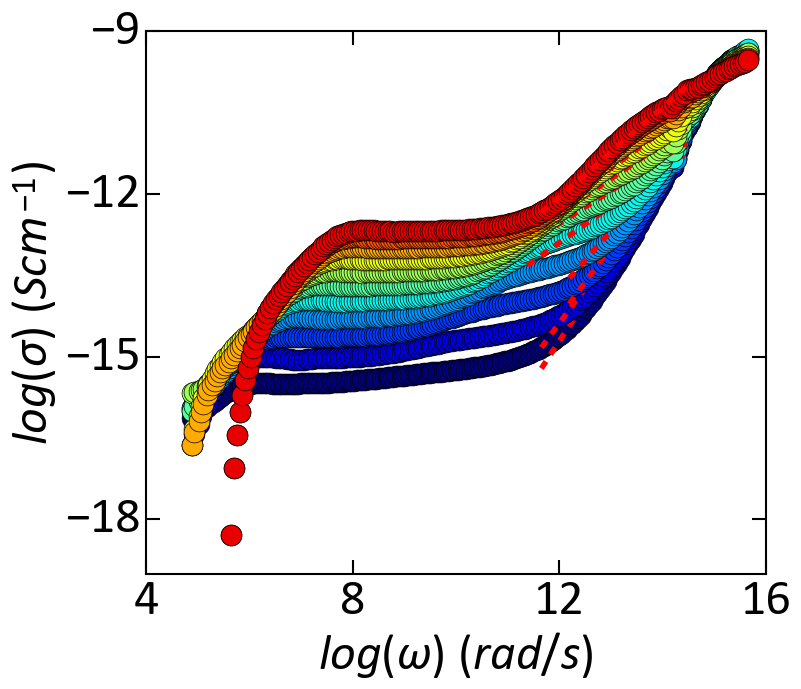

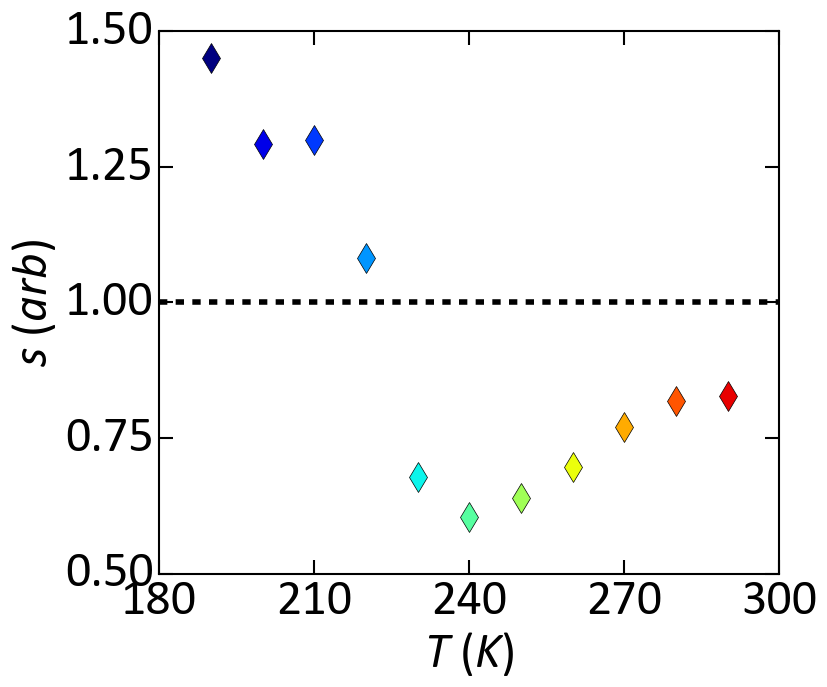

In [31]:
# plot of ln(sigma) vs. ln(frequency) with fits at all T 

# plot the data with fits
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(np.log(w2(t)),np.log(sigmaG(t)),'o',color=tuple(colSet2[t]),markersize = 15)
    
#     ax.plot(np.log(w2(t)[bound3:bound4[t]]),lineLowF[t],'r')
    ax.plot(np.log(w2(t)[bound4[t]:bound5]),lineHighF[t],'r',linestyle = 'dashed')
        
ax.set_xlabel("$log(\\omega)$ ($rad/s$)")
ax.set_ylabel("$log(\\sigma)$ ($S cm^{-1}$)")
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
# figName = '\\G_highOmegaFits.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')

# plot s vs. T
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
#     ax.plot(T[t],sigmaLowF[0,t],'o',color=tuple(colSet2[t]),markersize = 15)
    ax.plot(T[t],sigmaHighF[0,t],'d',color=tuple(colSet2[t]),markersize = 15)
plt.axhline(1,color = 'k',linestyle='dashed')

ax.set_xlabel("$T$ ($K$)")
ax.set_ylabel("$s$ ($arb$)")
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.set_ylim([0.5,1.5])
# figName = '\\s_highOmega.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')


Inspect temperature-dependence of high frequency, hopping dominated regime (note, this is *not* DC transport, so in general we may not expect the exponential thermal activation factor). Pick 2 fixed $\omega$ values outside the range of the $\omega_{D}$ peaks and see what this looks like against T. 

In [32]:
print(wLine.shape)
print(wLineb.shape)
print(wLine2.shape)

print(wLineb)
print(T[0:3])

print(figDir)
print(fig2Dir)

NameError: name 'wLine' is not defined

In [ ]:
print(omega_t1)

1174466.0
High t, high omega: 0.1029433841793853 +\- 0.02668683135598566
Low t, high omega: 0.01474420693720071 +\- 0.0010562321523120304
energy difference: 0.08819917724218458
all t, low omega: 0.12452962381275756 +\- 0.009426207681787572
all t, omegaD: 0.2323540629544957 +\- 0.008296613445134242


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


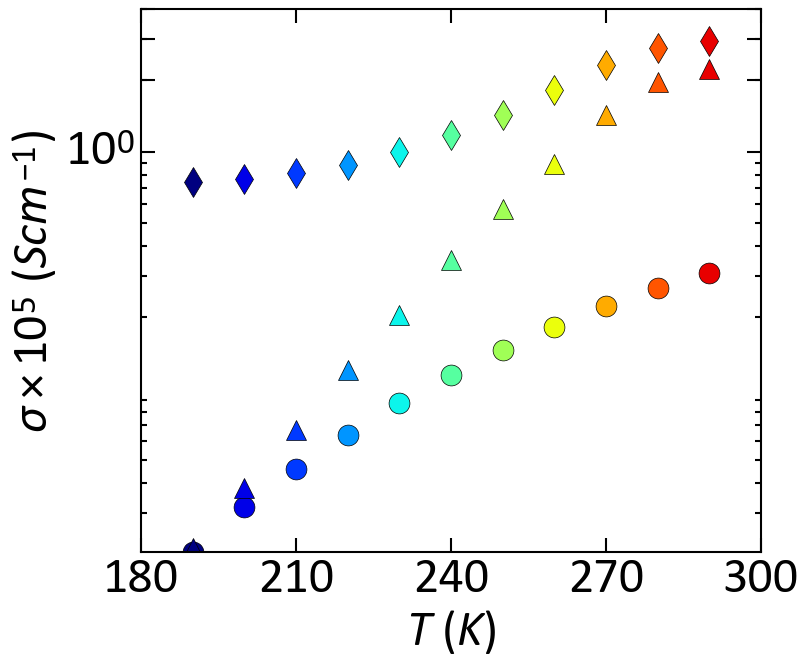

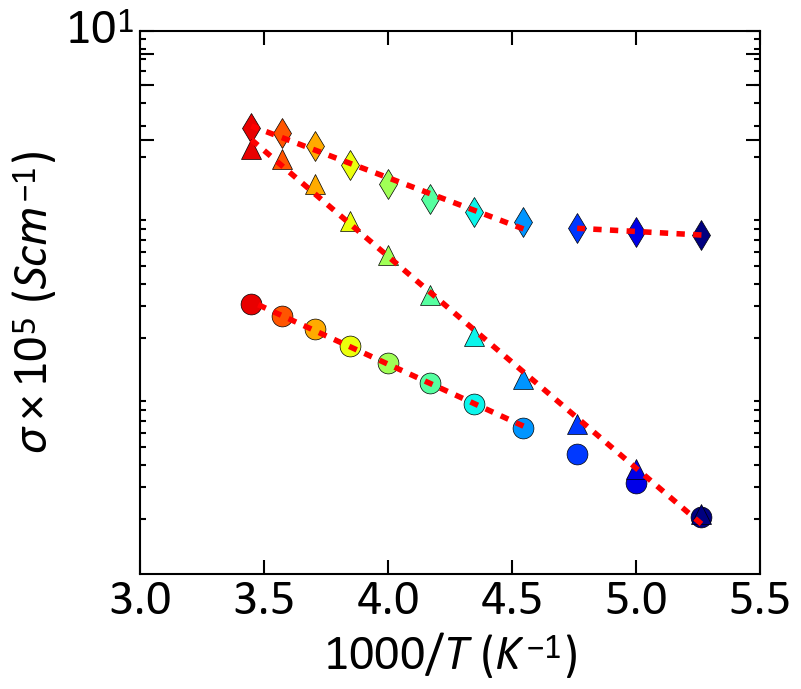

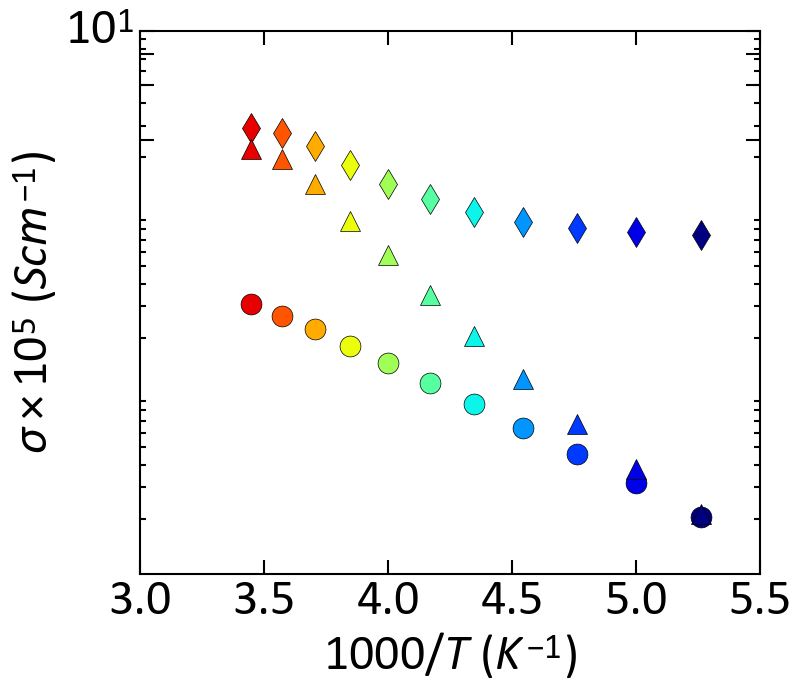

In [36]:
# first pick high omega index
print(w2(1)[bound5-10])

idxS = bound5-10
omegaS = w2(1)[idxS]

omegaSmat = np.zeros(tmax2)

for t in range(0,tmax2):
    omegaSmat[t] = sigmaG(t)[idxS]
    
# do same as above but for low omega
# print(np.where(w2(1) >= 5e3)[0][0])

idxs2 = np.where(w2(1) >= 5e3)[0][0]
omegaS2 = w2(1)[idxs2]

omegaSmat2 = np.zeros(tmax2)
for t in range(0,tmax2):
    omegaSmat2[t] = sigmaG(t)[idxs2]
    
# do same as above but for omega_{D}
omegaD_sigma = np.zeros(tmax2)

for t in range(0,tmax2):
    omegaD_sigma[t] = sigmaG(t)[omegaD_ix[t]]

    
# plot both low and high frequencies and omegaD for comparison
fig,ax = plt.subplots(1,1,figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(T[t],omegaSmat2[t]/1e-5,'o',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(T[t],omegaSmat[t]/1e-5,'d',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(T[t],omegaD_sigma[t]/1e-5,'^',color = tuple(colSet2[t]),markersize = 15)

# plt.axvline(215,color = 'r')
ax.set_xlabel("$T$ ($K$)")
ax.set_ylabel("$\\sigma \\times 10^{5}$ ($S cm^{-1}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim([180,300])
ax.set_ylim([-1,4])


# try fitting log(sigma[1,2,omegaD]) vs. 1/T to see what temp dependence is....

# create data arrays for high omega, high T 
xSigW1 = np.vstack( [1e3/T[3:],np.ones(len(T[3:]))]).T
ySigW1 = np.log(omegaSmat[3:])

# create data arrays for high omega, low T
xSigW1b = np.vstack( [1e3/T[0:3],np.ones(len(T[0:3]))]).T
ySigW1b = np.log(omegaSmat[0:3])

# create data arrays for low omega
# xSigW2 = np.vstack( [1e3/T[:],np.ones(len(T[:]))]).T
# ySigW2 = np.log(omegaSmat2[:])

xSigW2 = np.vstack( [1e3/T[3:],np.ones(len(T[3:]))]).T
ySigW2 = np.log(omegaSmat2[3:])

# create data arrays for omegaD
xSigWd = np.vstack( [1e3/T[:],np.ones(len(T[:]))]).T
ySigWd = np.log(omegaD_sigma[:])


# fit to high omega, high T with error estimates.
mW1,cW1 = np.linalg.lstsq(xSigW1,ySigW1)[0]
E_w1 = np.abs((kB*mW1)*1e3)
wLine1 =  np.exp(mW1*(1e3/T[3:])) * np.exp(cW1)
coeffW1 = np.array([mW1, cW1])
# error estimates
dLenW1 = len(ySigW1)
coeffLenW1 = len(coeffW1)
rmseW1 = np.sum((ySigW1 - np.dot(xSigW1,coeffW1))**2)/(dLenW1-coeffLenW1)
covMatW1 = rmseW1*np.linalg.inv(np.dot(xSigW1.T,xSigW1))
stdErrW1 = np.sqrt(np.diagonal(covMatW1))
E_w1err = stdErrW1[1]*E_w1

# wLine =  np.exp(mW*(1e3/T[:])) * np.exp(cW)
# print(tauLine)

# fit to high omega, low T with error estimates
mW1b,cW1b = np.linalg.lstsq(xSigW1b,ySigW1b)[0]
E_w1b = np.abs((kB*mW1b)*1e3)
wLine1b =  np.exp(mW1b*(1e3/T[0:3])) * np.exp(cW1b)
coeffW1b = np.array([mW1b, cW1b])
# error estimates
dLenW1b = len(ySigW1b)
coeffLenW1b = len(coeffW1b)
rmseW1b = np.sum((ySigW1b - np.dot(xSigW1b,coeffW1b))**2)/(dLenW1-coeffLenW1)
covMatW1b = rmseW1b*np.linalg.inv(np.dot(xSigW1b.T,xSigW1b))
stdErrW1b = np.sqrt(np.diagonal(covMatW1b))
E_w1bErr = stdErrW1b[1]*E_w1b

# fit to low omega
mW2,cW2 = np.linalg.lstsq(xSigW2,ySigW2)[0]
E_w2 = np.abs((kB*mW2)*1e3)
# wLine2 =  np.exp(mW2*(1e3/T[:])) * np.exp(cW2)
wLine2 =  np.exp(mW2*(1e3/T[3:])) * np.exp(cW2)
coeffW2 = np.array([mW2, cW2])
# error estimates
dLenW2 = len(ySigW2)
coeffLenW2 = len(coeffW2)
rmseW2 = np.sum((ySigW2 - np.dot(xSigW2,coeffW2))**2)/(dLenW2-coeffLenW2)
covMatW2 = rmseW2*np.linalg.inv(np.dot(xSigW2.T,xSigW2))
stdErrW2 = np.sqrt(np.diagonal(covMatW2))
E_w2err = stdErrW2[1]*E_w2


# fit to omegaD
mWd,cWd = np.linalg.lstsq(xSigWd,ySigWd)[0]
# print(mt,ct)
E_wd = np.abs((kB*mWd)*1e3)
wLined =  np.exp(mWd*(1e3/T[:])) * np.exp(cWd)
coeffWd = np.array([mWd, cWd])
# error estimates
dLenWd = len(ySigWd)
coeffLenWd = len(coeffWd)
rmseWd = np.sum((ySigW2 - np.dot(xSigW2,coeffW2))**2)/(dLenWd-coeffLenWd)
covMatWd = rmseWd*np.linalg.inv(np.dot(xSigWd.T,xSigWd))
stdErrWd = np.sqrt(np.diagonal(covMatWd))
E_wdErr = stdErrWd[1]*E_wd


# plot data and fits
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(1e3/T[t],omegaSmat2[t]/1e-5,'o',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],omegaSmat[t]/1e-5,'d',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],omegaD_sigma[t]/1e-5,'^',color = tuple(colSet2[t]),markersize = 15)

ax.plot(1e3/T[3:],wLine1[:]*1e5,color = 'r', linestyle='dashed' )
ax.plot(1e3/T[0:3],wLine1b[:]*1e5,color = 'r',linestyle='dashed' )
ax.plot(1e3/T[3:],wLine2[:]*1e5,color = 'r',linestyle='dashed' )
ax.plot(1e3/T[:],wLined[:]*1e5,color = 'r',linestyle='dashed' )
ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\sigma \\times 10^{5}$ ($S cm^{-1}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\sigmaArrFits_multiW.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')

# plot data 
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,tmax2):
    ax.plot(1e3/T[t],omegaSmat2[t]/1e-5,'o',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],omegaSmat[t]/1e-5,'d',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],omegaD_sigma[t]/1e-5,'^',color = tuple(colSet2[t]),markersize = 15)
    
ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\sigma \\times 10^{5}$ ($S cm^{-1}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))


print('High t, high omega: {}'.format(E_w1) + ' +\- {}'.format(E_w1err))
print('Low t, high omega: {}'.format(E_w1b) + ' +\- {}'.format(E_w1bErr))
print('energy difference: {}'.format(E_w1-E_w1b))
print('all t, low omega: {}' .format(E_w2) + ' +\- {}'.format(E_w2err))
print('all t, omegaD: {}' .format(E_wd) + ' +\- {}'.format(E_wdErr))



In [62]:
print(len(nu_ph[1,:]))
print(len(1e3/T[3:tmax2]))
print(len(1e3/T[3:]))
print(range(3,tmax2))


print(len(sLine2[:]))

11
8
8
range(3, 11)
3


In [80]:
print(xSd)
print(np.exp(ySd))
print(nu_ph[2,3:])

[[ 4.54545455  1.        ]
 [ 4.34782609  1.        ]
 [ 4.16666667  1.        ]
 [ 4.          1.        ]
 [ 3.84615385  1.        ]
 [ 3.7037037   1.        ]
 [ 3.57142857  1.        ]
 [ 3.44827586  1.        ]]
[  1.94791429e-17   2.05548612e+10   3.25050929e+09   1.48307108e+10
   1.81402872e+11   1.91661704e+13   2.16676129e+15   8.17191563e+15]
[  1.94791429e-17   2.05548612e+10   3.25050929e+09   1.48307108e+10
   1.81402872e+11   1.91661704e+13   2.16676129e+15   8.17191563e+15]


[  1.94791429e-17   2.05548612e+10   3.25050929e+09   1.48307108e+10
   1.81402872e+11   1.91661704e+13   2.16676129e+15   8.17191563e+15]
[  4.94127108e-16   2.92193000e+11   2.81120224e+10   7.67218676e+10
   6.31675478e+11   4.46335049e+13   3.84478676e+15   1.31402479e+16]
[  4.20724915e-18   2.48787959e+09   2.39360036e+08   6.53248945e+08
   5.37840583e+09   3.80032328e+11   3.27364671e+13   1.11882744e+14]
The B parameter measured at high frequency is 1.7355926341301977+/- 4.177540637349757
The B parameter measured at omega D is 1.9435614936385401+/- 4.565370708338
The B parameter measured at low frequency is 1.735592634130197+/- 4.177540637349755
[ 2.40698223  9.14004507]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


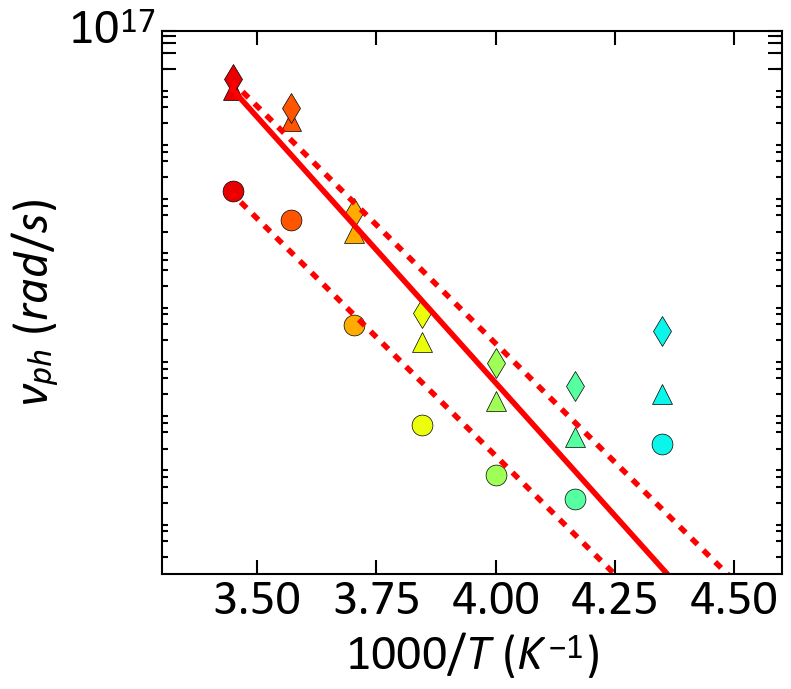

In [112]:
# calculate nu_ph based on equations from Mott. 

sFac = np.zeros(tmax2)
nu_ph = np.zeros((3,tmax2))

for t in range(3,tmax2):
    sFac[t] = sigmaHighF[0,t]
    nu_ph[0,t] = np.exp(-4/(sFac[t]-1))*w2(t)[idxS]
    nu_ph[1,t] = np.exp(-4/(sFac[t]-1))*1e4
    nu_ph[2,t] = np.exp(-4/(sFac[t]-1))*omegaD[t]
    
print(nu_ph[2,3:])
print(nu_ph[0,3:])
print(nu_ph[1,3:])


# create data arrays for high omega
xS1 = np.vstack( [1e3/T[5:],np.ones(len(T[5:]))]).T
yS1 = np.log(nu_ph[0,5:])

# create data arrays for omegaD
xSd = np.vstack( [1e3/T[5:],np.ones(len(T[5:]))]).T
ySd = np.log(nu_ph[2,5:])

# create data arrays for low omega 
xS2 = np.vstack( [1e3/T[5:],np.ones(len(T[5:]))]).T
yS2 = np.log(nu_ph[1,5:])

# fit to high omega with error estimates
ms1,cs1 = np.linalg.lstsq(xS1,yS1)[0]
B1 = abs((kB*ms1)*1e3)
sLine1 =  np.exp(ms1*(1e3/T[:])) * np.exp(cs1)
coeffS1 = np.array([ms1, cs1])
# error estimates
sLen1 = len(yS1)
coeffLenS1 = len(coeffS1)
rmseS1 = np.sum((yS1 - np.dot(xS1,coeffS1))**2)/(sLen1-coeffLenS1)
covMatS1 = rmseS1*np.linalg.inv(np.dot(xS1.T,xS1))
stdErrS1 = np.sqrt(np.diagonal(covMatS1))
B1Err = stdErrS1[0]*B1

# fit to omegaD with error estimates
msd,csd = np.linalg.lstsq(xSd,ySd)[0]
Bd = abs((kB*msd)*1e3)
sLined =  np.exp(msd*(1e3/T[:])) * np.exp(csd)
coeffSd = np.array([msd, csd])
# error estimates
sLenD = len(ySd)
coeffLenSd = len(coeffSd)
rmseSd = np.sum((ySd - np.dot(xSd,coeffSd))**2)/(sLenD-coeffLenS1)
covMatSd = rmseSd*np.linalg.inv(np.dot(xSd.T,xSd))
stdErrSd = np.sqrt(np.diagonal(covMatSd))
BdErr = stdErrSd[0]*Bd

# fit to high omega with error estimates
ms2,cs2 = np.linalg.lstsq(xS2,yS2)[0]
B2 = abs((kB*ms2)*1e3)
sLine2 =  np.exp(ms2*(1e3/T[:])) * np.exp(cs2)
coeffS2 = np.array([ms2, cs2])
# error estimates
sLen2 = len(yS2)
coeffLenS2 = len(coeffS2)
rmseS2 = np.sum((yS2 - np.dot(xS2,coeffS2))**2)/(sLen2-coeffLenS2)
covMatS2 = rmseS2*np.linalg.inv(np.dot(xS2.T,xS2))
stdErrS2 = np.sqrt(np.diagonal(covMatS2))
B2Err = stdErrS2[0]*B2



# plot ln(nu_ph) vs. 1/T with fits
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax2):
    ax.plot(1e3/T[t],nu_ph[2,t],'^',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],nu_ph[1,t],'o',color = tuple(colSet2[t]),markersize = 15)
    ax.plot(1e3/T[t],nu_ph[0,t],'d',color = tuple(colSet2[t]),markersize = 15)

    
ax.plot(1e3/T[:],sLine1[:],color = 'r', linestyle='dashed' )
ax.plot(1e3/T[:],sLined[:],color = 'r',linestyle='-' )
ax.plot(1e3/T[:],sLine2[:],color = 'r',linestyle='dashed' )
ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\nu_{ph}$ ($rad/s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.set_xlim([3.3,4.6])
ax.set_ylim([1e7,1e17])
# figName = '\\sigmaArrFits_multiW.png'
# plt.savefig(fig2Dir + figName,dpi = 300,bbox_inches = 'tight')


print('The B parameter measured at high frequency is {}'.format(B1) +  '+/- {}'.format(B1Err))
print('The B parameter measured at omega D is {}'.format(Bd) +  '+/- {}'.format(BdErr))
print('The B parameter measured at low frequency is {}'.format(B2) +  '+/- {}'.format(B2Err))



(-50, 400)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


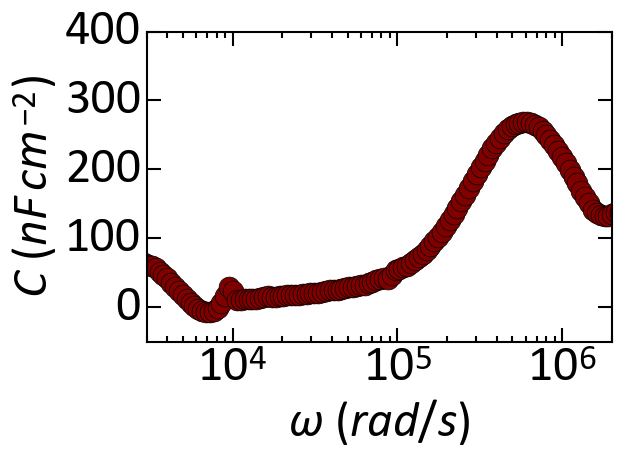

In [100]:
fix,ax = plt.subplots(1,1)
ax.plot(w2(tmax2-1),wdCdW(tmax2-1),'o',color=tuple(colSet2[tmax2-1]),markersize = 15)
ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$-\omega \\frac{dC}{d \omega}$ ($nF\, cm^{-2}$)")
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_xlim([3e3,2e6])
ax.set_ylim([-50,400])

In [110]:
# extract fitbounds for the 
fitB1 = max(np.where(w2(1) >= 1.2e4))[0]
fitB2 = max(np.where(w2(1) >= 2e6))[0]

print(fitB1,fitB2)


84 178


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 94
    # variables        = 3
    chi-square         = 1983012.24
    reduced chi-square = 21791.3433
    Akaike info crit   = 941.942283
    Bayesian info crit = 949.572167
[[Variables]]
    sigma:      100000.000 +/- 0.00000000 (0.00%) (init = 100000)
    amplitude:  300.000000 +/- 0.00000000 (0.00%) (init = 300)
    center:     800000.011 +/- 0.00000000 (0.00%) (init = 800000)



(-50, 400)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


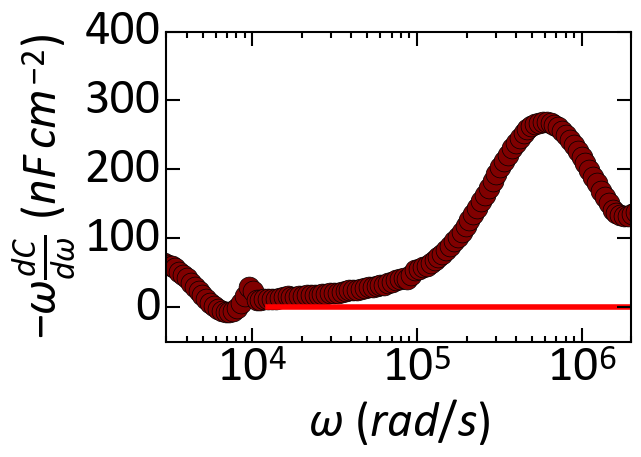

In [142]:
from lmfit.models import GaussianModel

Tt = tmax2-1

# define the model and the data
gaussMod = GaussianModel()
data = wdCdW(Tt)[fitB1:fitB2]

# add parameters with guesses
params = lmf.Parameters() 

params.add('sigma', value = 1e5, min = 5e4, max = 1e6)
# params.add('sigma', value = 1e2, min = 1e2, max = 1e6)
params.add('amplitude', value = 300, min = 250, max = 350)
params.add('center', value = 8e5, min = 3e5, max = 3e6)

# tell lmfit to guess the initial values
# gaussMod.guess_starting_values(data, x = np.log(w2(Tt)[fitB1:fitB2]))

# perform the fit
gaussResult = gaussMod.fit(data, x = np.log(w2(Tt)[fitB1:fitB2]), params = params)

print(gaussResult.fit_report())


fix,ax = plt.subplots(1,1)
ax.plot(w2(Tt),wdCdW(tmax2-1),'o', color = tuple(colSet2[Tt]),markersize = 15)
ax.plot(w2(Tt)[fitB1:fitB2],gaussResult.best_fit,color = 'r')
ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$-\omega \\frac{dC}{d \omega}$ ($nF\, cm^{-2}$)")
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(5))
# ax.xaxis.set_major_locator(MaxNLocator(2))
ax.set_xlim([3e3,2e6])
ax.set_ylim([-50,400])




Export the arrays for best fits to equivalent circuit model and extracted parameters as a .mat file so that we can make all the figures look the same

In [152]:
import scipy.io

# save the results of the G-omega fits, including extracted C, tau, and R values with assoaciated error arrays
scipy.io.savemat('gOmegaFits', dict(pyW = master0mv[:,:,0] ,pyGw = gOmega[:,:,1], fitLinesTot = fitResult_tot, fitXvalsTot = , Rt1 = Rt1, Rt2 = Rt2, Rt1_err = Rt1_err, Rt2_err = Rt2_err, pyT = T, gBound1 = bound1, gBound2 = bound2, omega_t1 = omega_t1, omega_t2 = omega_t2, ta1_val = tau1_val, tau2_val = tau2_val, tau1_valErr = tau1_valErr, tau2_valErr = tau2_valErr))


In [148]:
scipy.io.savemat('test1', dict( pyT1 = Rt1, pyT2 = Rt2, pyT3 = Rt1_err, pyT4 = Rt2_err, pyT5 = fitResult_tot) )

In [ ]:
for t in range(0,tmax):

    params.add('t1_Ct',value = 9e-7, min = 1e-7, max = 2e-6)
    # params.add('t1_tau_t',value = tau1, vary = False, min = 0, max = 1e-1)
    params.add('t1_tau_t',value = tau1[t], min = 0, max = 1e-2)

    params.add('t2_Ct',value = 1e-8, min = 0, max = 1e-7)
    # params.add('t2_tau_t',value = tau2,vary = False, min = 0, max = 1e-3)
    params.add('t2_tau_t', value = tau2[t], min = 0, max = 2e-4)

    # ensure data is run over proper range
    data = (Gw(t)[bound1[t]:bound2[t]])
    weights = 1/(.02*Zmag(t)[bound1[t]:bound2[t]])

    #try the fit
    fit_result = gModel.fit(data, w = w(t)[bound1[t]:bound2[t]],params = params,weights = weights)
    
    Ct1_fits.append(fit_result.params['t1_Ct'].value)
    tau1_fits.append(fit_result.params['t1_tau_t'].value)
    Ct2_fits.append(fit_result.params['t2_Ct'].value)
    tau2_fits.append(fit_result.params['t2_tau_t'].value)
    
    Ct1_err.append(fit_result.params['t1_Ct'].stderr)
    tau1_err.append(fit_result.params['t1_tau_t'].stderr)
    Ct2_err.append(fit_result.params['t2_Ct'].stderr)
    tau2_err.append(fit_result.params['t2_tau_t'].stderr)
    
    fitResult_tot.append(fit_result.best_fit)
    
    print(t)
    print(fit_result.fit_report())


    # G/w with fit
    fig,ax = plt.subplots(1,1)
    ax.plot(w(t),Gw(t),'o',c = tuple(colSet[t]), markersize = 10)
    ax.plot(w(Tt)[bound1[t]:bound2[t]],fit_result.best_fit,color = 'r')

2.66860761078e-08


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


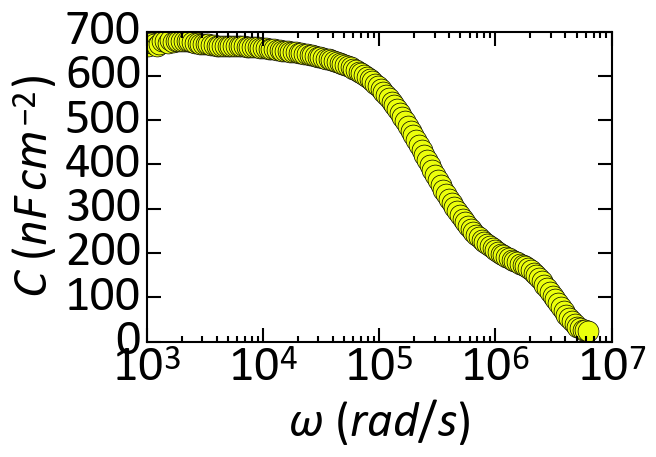

In [133]:
fig,ax = plt.subplots(1,1)
ax.plot(w2(7),C(7),'o',color=tuple(colSet2[7]),markersize = 15)

# ax.plot(w2(tmax2-1)[157],C(tmax2-1)[157],'r*')
ax.set_xlabel("$\\omega$ ($rad/s$)")
ax.set_ylabel("$C$ ($nF\, cm^{-2}$)")
ax.set_xscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim([1e3,1e7])

wtest = np.where(w2(t) >= 1e3)[0][0]
print((C(7)[wtest]*4e-2)/1e9)

In [139]:
# freeze out check (foc)


focG = np.zeros((2,tmax))
omegat1_idx = np.zeros(tmax)
omegat2_idx = np.zeros(tmax)


foc1 = np.zeros(tmax2)


for t in range(0,tmax):
    omegat1_idx[t] = np.where(w(t) >= omega_t1[t])[0][0]
    omegat2_idx[t] = np.where(w(t) >= omega_t2[t])[0][0]
    
    focG[0,t] = w(t)[omegat1_idx[t]]*Ct1_fits[t]*Rt1[t]
    focG[1,t] = w(t)[omegat2_idx[t]]*Ct2_fits[t]*Rt2[t]

print(focG)

for t in range(0,tmax2):
    foc1[t] = omegaD[t]*(1/omegaD_sigma[t])*C(t)[omegaD_ix]

[[ 6.43653516  6.34872578  6.28916378  6.46261523  6.28767636  6.44438455
   6.3688883   6.55705535]
 [ 6.52915694  6.51362982  6.43560596  6.31135153  6.46680595  6.45647289
   6.60127423  6.42381371]]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: setting an array element with a sequence.